# 导入模块与包

In [1]:
from vnpy.trader.utility import ArrayManager, BarGenerator, Interval
from vnpy.trader.object import BarData
from vnpy.trader.constant import *
import datetime as dt
import pandas as pd
import sqlite3
from collections import defaultdict
import math

from typing import List, Dict
from datetime import datetime

from vnpy_portfoliostrategy import (
    StrategyEngine,
    StrategyTemplate,
    TickData,
    BarData,
    TradeData,
    ArrayManager,
)

from vnpy_portfoliostrategy.utility import PortfolioBarGenerator
import numpy as np
import talib as ta

from typing import List, Dict
from datetime import datetime

## 自定义多空信号拟合类

In [2]:
class LongShortTemplate(StrategyTemplate):
    def __init__(self, cta_engine, strategy_name, vt_symbol, setting, LongStrategy, ShortStrategy):
        super().__init__(cta_engine, strategy_name, vt_symbol, setting)

        self.LongStrategy = LongStrategy(cta_engine, strategy_name, vt_symbol, setting)
        self.ShortStrategy = ShortStrategy(cta_engine, strategy_name, vt_symbol, setting)

        self.signal = 0

    def on_bar(self, bar: BarData):
        long_signal = self.LongStrategy.on_bar(bar)
        short_signal = self.ShortStrategy.on_bar(bar)
        self.signal = long_signal+short_signal

        return self.signal
        

# 读取数据

In [3]:
class MyDataReader:
    def __init__(self, SYMBOL_LIST=[]):
        self.DATA = None
        self.SYMBOL_LIST = SYMBOL_LIST
        self.DATA_DF = pd.DataFrame()
        self.VOLUME_DF = pd.DataFrame()
        
    ### self-defined
    @staticmethod
    def getTable(type_, symbol, start, end):
        database_path = './data/coindata.db'
        table_name = 'klines'

        conn = sqlite3.connect(database_path)

        query = f"""
        SELECT *
        FROM klines
        WHERE symbol = '{symbol}'
        AND date_time BETWEEN '{start}' AND '{end}'
        """
        data = pd.read_sql_query(query, conn)

        conn.close()

        return data
    
    def update_symbol_list(self, l:list):
        self.SYMBOL_LIST = l
        
    def get_new_data_instrument(self, start, end, inst):
        
        print(f"正在读取 {inst} 的数据")
        if start and end:
            print(f"时间范围: 从 {start} 到 {end}")
            
        #exchanges = 'binance-futures'
        symbols=[inst]
        type_ = "futures_um"
        #name = "norm_1min"

        #self-defined
        newdata = MyDataReader.getTable(type_, symbols[0], start, end)
        cols = ['date_time', 'open', 'high', 'low', 'close', 'volume']
        newdata = newdata[cols].rename(columns={'date_time': 'DateTime'})
        #data['DateTime'] -= pd.Timedelta(minutes=1)   ##unnecessary because my datetime is opentime, not closetime
        newdata = newdata.drop_duplicates(subset=['DateTime'])
        newdata = newdata.set_index('DateTime').sort_index()
        newdata["symbol"] = inst
        newdata = newdata.reset_index()
        
        if self.DATA is None:
            # 如果self.data为空,直接赋值
            self.DATA = newdata
        else:
            # 如果self.data不为空,将新数据添加到现有数据中
            self.DATA = pd.concat([self.DATA, newdata], ignore_index=True)
        
        return newdata

    def get_new_data_instruments(self, start, end):
        data = {}
        volume = {}
        
        for s in self.SYMBOL_LIST:
            d = self.get_new_data_instrument(start, end , s)
            data[s] = d[['close']]
            volume[s] = d[['volume']]
        
        datadf = pd.concat(list(data.values()), axis=1)
        datadf.columns = list(data.keys())

        voldf = pd.concat(list(volume.values()), axis=1)
        voldf.columns = list(volume.keys())
        
        datadf.index = pd.to_datetime(datadf.index)
        voldf.index = pd.to_datetime(voldf.index)
        
        self.DATA_DF = datadf
        self.VOLUME_DF = voldf

In [11]:
SYMBOL_LIST = ['BTCUSDT', "ETHUSDT"]
start = "2024-05-30"
end = "2024-07-31"

In [12]:
data_reader = MyDataReader()

In [13]:
data_reader.update_symbol_list(SYMBOL_LIST)
data_reader.get_new_data_instruments(start, end)

正在读取 BTCUSDT 的数据
时间范围: 从 2024-05-30 到 2024-07-31
正在读取 ETHUSDT 的数据
时间范围: 从 2024-05-30 到 2024-07-31


In [14]:
sample_data = data_reader.DATA

In [15]:
exchange:Exchange.LOCAL
interval = Interval.MINUTE

In [16]:
sample_data = sample_data.rename(columns = {"DateTime":"datetime", "open":"open_price", "high":"high_price", "low":"low_price", "close":"close_price"})

In [17]:
sample_data["exchange"] = Exchange.LOCAL
sample_data["interval"] = Interval.MINUTE

In [ ]:
def create_bar_data(row):
    return BarData(
        gateway_name=None,  # 替换为实际的网关名称
        symbol=row['symbol'],
        exchange=row['exchange'],  # 提取 'LOCAL'
        datetime=row['datetime'],
        interval=row['interval'],  # 提取 'MINUTE'
        volume=row['volume'],
        open_price=row['open_price'],
        high_price=row['high_price'],
        low_price=row['low_price'],
        close_price=row['close_price']
    )

# 跨币种策略 (未完成)

In [39]:
from typing import List, Dict
from datetime import datetime

from vnpy_portfoliostrategy import (
    StrategyEngine,
    StrategyTemplate,
    TickData,
    BarData,
    TradeData,
    ArrayManager,
)

from vnpy.trader.utility import Interval
from vnpy_portfoliostrategy.utility import PortfolioBarGenerator
import numpy as np
import talib as ta

## 跨品种动量策略（未完成）

### 策略内容

In [29]:
class CrossPairMomStrategy(StrategyTemplate):
    """跨品种动量策略"""
    """该策略返回的多空信号是基于传入的第一个标的的，即出现1即看多A但看空B，出现-1即看空A但看多B"""

    author = "Your Name"

    # 默认策略参数
    N = 20
    M = 2
    X = 0.5
    fixed_size = 1
    TRS = 20

    # 时间周期参数
    short_period = 1    # 1分钟K线
    long_period = 2     # 2小时K线
    long_interval = Interval.HOUR  # 长周期的时间单位

    # 策略变量
    K = 0
    star_N = 0
    MIN_L = 0
    MAX_H = 0
    KG = 0
    high_after_entry = 0
    low_after_entry = 0
    dliq_point = 0
    kliq_point = 0

    parameters = ["N", "M", "X", "fixed_size", "TRS", "short_period", "long_period", "long_interval"]
    variables = ["K", "star_N", "MIN_L", "MAX_H", "KG", "high_after_entry", "low_after_entry", "dliq_point", "kliq_point"]

    def __init__(self, strategy_engine: StrategyEngine, strategy_name: str, vt_symbols: List[str], setting: dict):
        """初始化策略实例，接收外部传入的参数设置。"""
        super().__init__(strategy_engine, strategy_name, vt_symbols, setting)

        # 从setting字典中获取参数值
        self.N = setting.get("N", self.N)
        self.M = setting.get("M", self.M)
        self.X = setting.get("X", self.X)
        self.fixed_size = setting.get("fixed_size", self.fixed_size)
        self.TRS = setting.get("TRS", self.TRS)
        self.short_period = setting.get("short_period", self.short_period)
        self.long_period = setting.get("long_period", self.long_period)
        self.long_interval = setting.get("long_interval", self.long_interval)

        self.targets: Dict[str, int] = {}
        self.last_tick_time: datetime = None

        # 初始化 ArrayManager 和 PortfolioBarGenerator
        self.ams: Dict[str, ArrayManager] = {}
        for vt_symbol in self.vt_symbols:
            self.ams[vt_symbol] = ArrayManager()
            self.targets[vt_symbol] = 0

        # 初始化不同周期的 BarGenerator
        self.pbg_short = PortfolioBarGenerator(self.on_bars, self.short_period, self.on_timeframe_bars, Interval.MINUTE)
        self.pbg_long = PortfolioBarGenerator(self.on_bars, self.long_period, self.on_timeframe_bars, self.long_interval)

    def on_init(self):
        """策略初始化回调函数。"""
        self.write_log("策略初始化")
        self.load_bars(10)

    def on_start(self):
        """策略启动回调函数。"""
        self.write_log("策略启动")

    def on_stop(self):
        """策略停止回调函数。"""
        self.write_log("策略停止")

    def on_tick(self, tick: TickData):
        """Tick数据更新回调函数。"""
        self.pbg_short.update_tick(tick)

    def on_bars(self, bars: Dict[str, BarData]):
        """K线数据更新回调函数。"""
        self.pbg_short.update_bars(bars)
        self.pbg_long.update_bars(bars)

    def on_timeframe_bars(self, bars: Dict[str, BarData]) -> int:
        """通用K线数据处理函数，返回看多（1）或看空（-1）的信号，未触发信号则返回0。"""
        self.cancel_all()
        nx = 0

        for vt_symbol, bar in bars.items():
            nx += 1
            am: ArrayManager = self.ams[vt_symbol]
            am.update_bar(bar)

            if not am.inited:
                return 0

            if nx == 1:
                am_1 = am
            elif nx == 2:
                am_2 = am

        
        # 计算价比、开比、最高比、最低比
        c_jb = am_1.close_array / am_2.close_array
        copen = am_1.open_array / am_2.open_array
        chigh = np.maximum(np.maximum(am_1.high_array / am_2.high_array, copen), c_jb)
        clow = np.minimum(np.minimum(am_1.low_array / am_2.low_array, copen), c_jb)

        
        # 计算MA
        Ma1 = ta.EMA(c_jb, self.N)
        Ma60 = ta.EMA(c_jb, self.N * self.M)


        # 计算最高价比和最低价比
        HH = np.max(chigh[-self.N:-1])
        LL = np.min(clow[-self.N:-1])

        # 计算线性指标
        Linear = ((Ma60[-1] - Ma60[-2]) / Ma60[-1] * 1000) / 10
        condtion1 = Ma1[-1] > Ma60[-1] and Ma1[-2] <= Ma60[-2]
        condtion2 = Ma1[-1] < Ma60[-1] and Ma1[-2] >= Ma60[-2]

        if condtion1:
            self.star_N = Linear
            self.K = 0
            self.MIN_L = Linear
        if condtion2:
            self.star_N = Linear
            self.K = 0
            self.MAX_H = Linear
        if self.K == 0:
            self.MIN_L = min(Linear, self.MIN_L)
            self.MAX_H = max(Linear, self.MAX_H)

        AO_condtiond = Linear > self.MIN_L and Linear > self.star_N * (1 + self.X) and self.MIN_L <= self.star_N
        TU_condtiond = Linear < self.MAX_H and Linear < self.star_N * (1 - self.X) and self.MAX_H >= self.star_N

        if AO_condtiond and Ma1[-1] > Ma60[-1] and self.star_N != 0:
            self.K = 1
            self.star_N = 0
        elif TU_condtiond and Ma1[-1] < Ma60[-1] and self.star_N != 0:
            self.K = -1
            self.star_N = 0

        cond_dk = self.K > 0 and chigh[-1] > HH
        cond_kk = self.K < 0 and clow[-1] < LL
        self.KG = 1 if cond_dk else -1 if cond_kk else 0

        # 返回看多或看空信号
        return self.KG

### 回测

In [54]:
'''测试'''

import pandas as pd
from datetime import datetime
from vnpy.trader.object import BarData
from vnpy.trader.constant import Interval, Exchange

# 假设 sample_data 是你加载的 pandas DataFrame
# 示例: sample_data = pd.read_csv("your_data.csv")

# 初始化策略引擎
strategy_engine = None  # 不需要实际交易引擎，只需传入 None

# 设置策略参数
setting = {
    "N": 20,
    "M": 3,
    "X": 0.7,
    "fixed_size": 1,
    "TRS": 20,
    "short_period": 1,
    "long_period": 2,
    "long_interval": Interval.HOUR
}

# 创建策略实例
strategy = CrossPairMomStrategy(
    strategy_engine=strategy_engine,
    strategy_name="CrossPairMom",
    vt_symbols=["BTCUSDT.LOCAL", "ETHUSDT.LOCAL"],
    setting=setting
)


# 根据datetime字段对数据分组
grouped_data = sample_data.groupby("datetime")

signals = []
# 遍历每个时间步的数据
for datetime_str, group in grouped_data:
    bars = {}

    for _, row in group.iterrows():
        # 将每一行数据转换为 BarData 对象
        bar = BarData(
            symbol=row["symbol"],
            exchange=Exchange.LOCAL,  # 假设都是本地交易所
            datetime=pd.to_datetime(row["datetime"]),
            interval=Interval.MINUTE,  # 假设都是1分钟K线
            volume=row["volume"],
            open_price=row["open_price"],
            high_price=row["high_price"],
            low_price=row["low_price"],
            close_price=row["close_price"],
            gateway_name="LOCAL"  # 假设使用的是本地网关
        )
        bars[f"{row['symbol']}.LOCAL"] = bar

    
    # 调用策略的 on_bars 方法处理该时间步的Bar数据
    strategy.on_bars(bars)
    signals.append({row["datetime"]:{list(bars.keys())[0]:(type(strategy).__name__, strategy.KG)}})

# 单币种策略

## 单币种简易回测函数

In [18]:
def simply_backtest(strategy_class, symbol="BTCUSDT"):
    # 加载BTC K线数据
    data = sample_data[sample_data["symbol"] == symbol]
    
    # 初始化策略引擎
    strategy_engine = None  # 不需要实际交易引擎，只需传入 None
    
    # 策略参数设置
    setting = {
        }
    
    # 初始化策略
    strategy = strategy_class(cta_engine=strategy_engine,
            strategy_name="Test",
            vt_symbol="{symbol}.LOCAL",
            setting= setting)
    
    signals = []
    for index, row in data.iterrows():
        bar = BarData(
            symbol=row["symbol"],
            exchange=Exchange.LOCAL,  # 如果是本地数据，请使用 LOCAL
            datetime=pd.to_datetime(row["datetime"]),
            interval=Interval.MINUTE,  # 假设数据是1分钟K线
            volume=row["volume"],
            open_price=row["open_price"],
            high_price=row["high_price"],
            low_price=row["low_price"],
            close_price=row["close_price"],
            gateway_name="LOCAL"
        )
    
        signal = strategy.on_bar(bar)  # 处理每一个1分钟K线，并生成信号
        signals.append((bar.datetime, signal))

    return strategy, signals

In [19]:
def set_signals(signals: List):
    return set([i[1] for i in signals])

## SuperTrend策略

### 策略内容

In [20]:
class SuperTrendStrategy(StrategyTemplate):

    # 参数列表
    parameters = [
        "ayami_multi", "extrem_filter", "er_trigger", "length", 
        "short_window", "long_window", "long_interval", "short_interval",
        "entry_threhold", "long_window_inited_length"
    ]

    def __init__(self, cta_engine, strategy_name, vt_symbol, setting):
        """"""
        super().__init__(cta_engine, strategy_name, vt_symbol, setting)

        # 从setting中加载参数
        self.ayami_multi = setting.get("ayami_multi", 3)  # Volatility multiplier
        self.extrem_filter = setting.get("extrem_filter", 2.8)  # Effratio filter
        self.er_trigger = setting.get("er_trigger", 0.7)  # Exit acceleration ratio
        self.length = setting.get("length", 21)  # Calculation period length
        self.short_window = setting.get("short_window", 15)  # 短周期长度（分钟）
        self.long_window = setting.get("long_window", 1)  # 长周期长度（天）
        self.long_interval = setting.get("long_interval", Interval.DAILY)  # 长周期的时间单位
        self.short_interval = setting.get("short_interval", Interval.MINUTE)  # 短周期的时间单位
        self.entry_threhold = setting.get("entry_threhold", 0.55)  # 入场阈值
        self.long_window_inited_length = setting.get("long_window_inited_length", 10)  # long am长度
        
        # 初始化策略变量
        self.ayami = np.zeros(self.length)
        self.atr_array = np.zeros(self.length)
        self.v_max_ = np.zeros(self.length)
        self.v_max_1 = np.zeros(self.length)
        self.mean_b_ = np.zeros(self.length)
        self.Tup = np.zeros(self.length)
        self.Tdown = np.zeros(self.length)
        self.NetChg1 = 0
        self.dir = np.zeros(self.length)
        self.NetChg = 0
        self.diff = np.zeros(150)
        self.diff1 = np.zeros(150)
        self.TotChg1 = 0
        self.TotChg = 0
        self.EffRatio1 = np.zeros(self.length)
        self.EffRatio = np.zeros(self.length)
        self.w_er = np.zeros(10)
        '''此处改为self.entry，因为在下方的判断中实际是同一判断条件'''
        self.entry = False
        #self.long_entry = False
        #self.short_entry = False
        self.shunka = 0
        self.Ayami_ = np.zeros(20)
        self.trend = np.zeros(20)
        self.shutdown_extreme = False
        self.no_open = False

        # 初始化BarGenerator和ArrayManager
        self.bg = BarGenerator(self.on_bar, self.short_window, self.on_short_window_bar, self.short_interval)
        self.am = ArrayManager()

        self.bg_long = BarGenerator(self.on_bar, self.long_window, self.on_long_window_bar, self.long_interval, daily_end = datetime(datetime.today().year, datetime.today().month, datetime.today().day, 23, 59).time())
        self.am_long = ArrayManager(self.long_window_inited_length)

        # 用于存储信号
        self.signal = 0

    def update_array(self, arr, value):
        """更新数组"""
        arr[:-1] = arr[1:]
        arr[-1] = value

    def on_bar(self, bar: BarData):
        """
        处理新K线数据
        """
        self.bg.update_bar(bar)
        self.bg_long.update_bar(bar)

        return self.signal

    def on_long_window_bar(self, bar: BarData):
        """处理日线周期K线"""
        self.am_long.update_bar(bar)

    def on_short_window_bar(self, bar: BarData):
        """
        处理短周期K线，生成多空信号
        """
        am = self.am
        am.update_bar(bar)
        if not am.inited or not self.am_long.inited:
            self.signal = 0
            return 
            
        self.exit_mul_1 = self.ayami_multi

        # 计算移动均线，类似于AMA，降低趋势变化的延迟
        self.shunka = int((self.length - 1) / 2)
        self.update_array(self.Ayami_, am.close_array[-1] + (am.close_array[-1] - am.close_array[-self.shunka]))
        self.update_array(self.ayami, sum(self.Ayami_) / self.length)

        # 计算ATR
        self.atr_array = am.atr(self.length, array=True)
        self.atr = max(self.atr_array[-self.length:])

        # 平滑ATR和波动率
        self.update_array(self.v_max_, abs(am.close_array[-1] - am.open_array[-1]))
        self.update_array(self.v_max_1, sum(self.v_max_) / self.length)
        self.v_max = max(self.v_max_1[-self.length:])
        self.update_array(self.mean_b_, (self.v_max + self.atr) / 2)
        self.mean_b = sum(self.mean_b_) / self.length

        # 计算上轨和下轨
        self.up = self.ayami[-1] + (self.ayami_multi * self.mean_b)
        self.down = self.ayami[-1] - (self.ayami_multi * self.mean_b)

        if self.ayami[-2] > self.Tup[-2]:
            self.update_array(self.Tup, max(self.down, self.Tup[-2]))
        else:
            self.update_array(self.Tup, self.down)

        if self.ayami[-2] < self.Tdown[-2]:
            self.update_array(self.Tdown, min(self.up, self.Tdown[-2]))
        else:
            self.update_array(self.Tdown, self.up)

        # 计算方向
        if self.ayami[-1] > self.Tdown[-2]:
            self.update_array(self.dir, 1)
        else:
            if self.ayami[-1] < self.Tup[-2]:
                self.update_array(self.dir, -1)
            else:
                self.update_array(self.dir, self.dir[-2])

        # 计算超级趋势线
        if self.dir[-1] == 1:
            self.ayami_2 = self.Tup[-1]
        else:
            self.ayami_2 = self.Tdown[-1]

        # 过滤震荡
        self.NetChg1 = abs(am.close_array[-1] - am.close_array[-50])
        self.update_array(self.diff1, abs(am.close_array[-1] - am.close_array[-2]))
        self.TotChg1 = sum(abs(self.diff1))
        if self.TotChg1 > 0:
            self.update_array(self.EffRatio1, self.NetChg1 / self.TotChg1 * 10)
        else:
            self.update_array(self.EffRatio1, 0)

        # 平滑eff ratio
        self.update_array(self.w_er, sum(self.EffRatio1[-self.length:]) / self.length)

        # 处理极端情况
        self.extrem = self.w_er[-1] > self.extrem_filter
        if self.extrem:
            self.no_open = True

        self.shutdown_extreme = self.w_er[-2] > self.entry_threhold > self.w_er[-1]
        if self.shutdown_extreme:
            self.no_open = False

        # 判断信号
        self.entry = self.w_er[-1]>self.entry_threhold
        if self.entry and self.no_open==False:
            if self.dir[-1] == 1:
                self.signal = 1
            elif self.dir[-1] == -1:
                self.signal = -1
            else: self.signal = 0
        else:
            self.signal = 0

### 回测

In [179]:
'''测试单一币种交易'''

import pandas as pd
from datetime import datetime
from vnpy.trader.constant import Interval, Exchange
from vnpy.trader.object import BarData
from vnpy_portfoliostrategy import (
    StrategyEngine,
    StrategyTemplate,
    TickData,
    BarData,
    TradeData,
    ArrayManager,
)

# 加载BTC K线数据
data = sample_data[sample_data["symbol"] == "BTCUSDT"]

# 初始化策略引擎
strategy_engine = None  # 不需要实际交易引擎，只需传入 None

# 设置策略参数
setting = {
    "ayami_multi": 3,
    "extrem_filter": 2.8,
    "er_trigger": 0.7,
    "length": 21,
    "short_window": 15,  # 短周期长度（如15分钟）
    "long_window": 1,  # 长周期长度（如1天）
    "short_interval":Interval.MINUTE,
    "long_interval": Interval.DAILY,  # 长周期的时间单位
    "entry_threhold":0.55,
    "long_window_inited_length":10,
}

# 创建策略实例
strategy = SuperTrendStrategy(
    cta_engine=strategy_engine,
    strategy_name="SuperTrend",
    vt_symbol="BTCUSDT.LOCAL",
    setting=setting
)

# 遍历K线数据并进行策略测试
signals = []
for index, row in data.iterrows():
    bar = BarData(
        symbol=row["symbol"],
        exchange=Exchange.LOCAL,  # 如果是本地数据，请使用 LOCAL
        datetime=pd.to_datetime(row["datetime"]),
        interval=Interval.MINUTE,  # 假设数据是1分钟K线
        volume=row["volume"],
        open_price=row["open_price"],
        high_price=row["high_price"],
        low_price=row["low_price"],
        close_price=row["close_price"],
        gateway_name="LOCAL"
    )

    # 调用策略的on_bar方法并获取信号
    signal = strategy.on_bar(bar)
    signals.append((bar.datetime, signal))

1.2374833110814671
1.3393571211619648
1.6992130801201333
1.7928753411093599
1.911024487560395
2.1114366270931675
2.314729357500867
2.564382616862866
2.6910954502207547
2.7356935558241573
2.7907866266552133
2.8704023595097454
3.1108463301927456
3.3059004068257707
3.5364908223274294
3.764474874970747
4.011437054906951
4.278257048039204
4.499202201455899
4.752823676527226
4.9556071988163835
3.9216760141802345
3.989218573880016
3.828652153701715
3.9217783709148972
3.979136135927976
3.950190668849368
3.8804080751696275
3.76673098916698
3.773197488262419
3.8419390896455887
3.9219850831469305
3.9323208747097858
3.7888175000039905
3.669834806982948
3.510209719737555
3.360519585271827
3.167228328307338
2.9556579834593646
2.7929863932354175
2.592917783625044
2.4554609256473205
2.3211777776217497
2.2086002914674996
2.0679621580983483
1.9336729535465087
1.8068244693338027
1.6736602200736415
1.5798215059138698
1.491191010347008
1.3851058249188015
1.2999462219499667
1.2172884061914477
1.155003751123

## SmallTrend策略

### 策略内容

In [21]:
class SmallTrendStrategy(StrategyTemplate):

    # 参数列表
    parameters = [
        "NT", "Lenth2", "RS", "X", "Lots", "TRS", 
        "short_window", "short_window_inited_length",
        "short_interval"
    ]

    # 变量列表
    variables = [
        "HighAfterEntry", "LowAfterEntry", "liQKA", 
        "DliqPoint", "KliqPoint", "TRS"
    ]

    def __init__(self, cta_engine, strategy_name, vt_symbol, setting):
        """"""
        super().__init__(cta_engine, strategy_name, vt_symbol, setting)

        # 从setting中加载参数
        self.NT = setting.get("NT", 25)  # 通道长度
        self.Lenth2 = setting.get("Lenth2", 30)  # KDJ长度
        self.RS = setting.get("RS", 90)  # 止盈参数
        self.X = setting.get("X", 5)  # 初始止损参数
        self.Lots = setting.get("Lots", 1)  # 每次开仓手数
        self.TRS = setting.get("TRS", 0)  # 移动止损参数
        self.short_window = setting.get("short_window", 1)  # 短周期窗口（分钟）
        self.short_window_inited_length = setting.get("short_window_inited_length", self.Lenth2 * 3)  # short am长度
        self.short_interval = setting.get("long_interval", Interval.MINUTE)  # 短周期的时间单位

        # 初始化内部变量
        self.barN = 0
        self.bars = []
        self.HH = []
        self.LL = []
        self.SIG = 0
        self.Curbar_H = 0
        self.Curbar_L = 0
        self.LowAfterEntry = 0
        self.HighAfterEntry = 0
        self.HighAfterEntrys = 0
        self.LowAfterEntrys = 0
        self.liQKA = 0
        self.DliqPoint = 0
        self.KliqPoint = 0
        self.open_bar = 0
        self.KG = []
        self.sumhl = []
        self.sumcl = []
        self.slowk = []
        self.slowd = []
        self.ATRMD = []
        self.Max_cond = False
        self.Min_cond = False
        self.HD = 0
        self.LD = 0
        self.callgo = 0
        self.outD = 0
        self.outK = 0
        self.routD = 0
        self.routK = 0
        self.DEntryPrice = 0
        self.KEntryPrice = 0

        self.signal = 0  # 初始化信号变量

        # 初始化BarGenerator和ArrayManager
        self.bg = BarGenerator(self.on_bar, self.short_window, self.on_short_window_bar, self.short_interval)
        self.am = ArrayManager(self.short_window_inited_length)
        self.bars = []
        self.KG.append(0)

    def on_bar(self, bar: BarData):
        """
        处理1分钟K线数据
        """
        self.bg.update_bar(bar)
        return self.signal

    def on_short_window_bar(self, bar: BarData):
        """
        处理短周期K线数据，生成多空信号
        """

        self.bars.append(bar)
        if len(self.bars) <= 2:
            return
        else:
            self.bars.pop(0)

        am = self.am
        am.update_bar(bar)
        if not am.inited:
            return

        self.barN += 1  # bar计数
        SlowLength = int(self.Lenth2 / 3)
        ma1 = am.ema(self.Lenth2 * 3, array=True)
        atr_array = am.atr(14, array=True)
        HighestValue = max(am.high_array[-self.Lenth2:-1])
        LowestValue = min(am.low_array[-self.Lenth2:-1])

        self.sumhl.append(HighestValue - LowestValue)
        self.sumcl.append(am.close_array[-1] - LowestValue)

        if len(self.sumhl) <= SlowLength or len(self.sumcl) <= SlowLength:
            return

        SumHLValue = sum(self.sumhl[-SlowLength:])
        SumCLValue = sum(self.sumcl[-SlowLength:])

        if SumHLValue != 0:
            self.slowk.append(SumCLValue / SumHLValue * 100)  # KDJ K
        else:
            self.slowk.append(0)

        if len(self.slowk) <= SlowLength:
            return

        self.slowd = ta.EMA(np.array(self.slowk), SlowLength)  # KDJ D

        # 金叉
        if self.slowk[-1] > self.slowd[-1] and self.slowk[-2] <= self.slowd[-1]:  # gold cross bar index
            self.Curbar_H = self.barN

        # 死叉
        elif self.slowk[-1] < self.slowd[-1] and self.slowk[-2] >= self.slowd[-1]:  # death cross bar index
            self.Curbar_L = self.barN

        self.Highup = max(am.high_array[-self.NT:-1])  # high price in NT period during gold cross
        self.Lowdown = min(am.low_array[-self.NT:-1])  # low price in NT period during death cross

        if self.slowk[-1] > self.slowd[-1] and self.slowk[-2] <= self.slowd[-1]:  # save highup to HD
            self.HD = self.Highup

        if self.slowk[-1] < self.slowd[-1] and self.slowk[-2] >= self.slowd[-1]:  # save lowdown to LD
            self.LD = self.Lowdown

        if self.slowk[-2] > self.slowd[-2] and self.slowk[-3] <= self.slowd[-2]:
            self.KG.append(1)
            self.signal = 1  # 多头信号
        elif self.slowk[-2] < self.slowd[-2] and self.slowk[-3] >= self.slowd[-2]:
            self.KG.append(-1)
            self.signal = -1  # 空头信号
        else:
            self.signal = 0  # 中性信号

        if len(self.KG) < 2:
            return

### 回测

In [109]:
import pandas as pd
from datetime import datetime

# 加载BTC K线数据
data = sample_data[sample_data["symbol"] == "BTCUSDT"]

# 初始化策略引擎
strategy_engine = None  # 不需要实际交易引擎，只需传入 None

# 设置策略参数
setting = {
    "NT": 25,
    "Lenth2": 30,
    "short_window":1
}

# 初始化策略
strategy = SmallTrendStrategy(
    cta_engine=strategy_engine,
    strategy_name="SuperTrend",
    vt_symbol="BTCUSDT.LOCAL",
    setting=setting
)


# 遍历K线数据并进行策略测试
signals = []
for index, row in data.iterrows():
    bar = BarData(
        symbol=row["symbol"],
        exchange=Exchange.LOCAL,  # 如果是本地数据，请使用 LOCAL
        datetime=pd.to_datetime(row["datetime"]),
        interval=Interval.MINUTE,  # 假设数据是1分钟K线
        volume=row["volume"],
        open_price=row["open_price"],
        high_price=row["high_price"],
        low_price=row["low_price"],
        close_price=row["close_price"],
        gateway_name="LOCAL"
    )

    # 调用策略的on_bar方法并获取信号
    signal = strategy.on_bar(bar)
    signals.append((bar.datetime, signal))

## SmallTrend_MV策略

### 策略内容

In [22]:
class SmallTrend_MV(StrategyTemplate):
    
    # 参数列表
    parameters = ["NT", "Lenth2", "TRS", "Lots", "callkg", "short_window", "long_window", "short_window_inited_length",
                 "long_window_inited_length", "long_interval", "short_interval"]

    def __init__(self, cta_engine, strategy_name, vt_symbol, setting):
        """"""
        super().__init__(cta_engine, strategy_name, vt_symbol, setting)

        # 从setting中加载参数
        self.NT = setting.get("NT", 200)  # 长期趋势通道的长度
        self.Lenth2 = setting.get("Lenth2", 200)  # 短期趋势参数
        self.TRS = setting.get("TRS", 200)  # 动态止损系数
        self.Lots = setting.get("Lots", 1)  # 每次开仓手数
        self.callkg = setting.get("callkg", False)  # 是否开启加仓功能
        self.short_window = setting.get("short_window", 5)  # 短周期窗口（默认5分钟）
        self.long_window = setting.get("long_window", 60)  # 长周期窗口（默认60分钟）
        self.short_window_inited_length = setting.get("short_window_inited_length", self.Lenth2 * 3)  # short am长度
        self.long_window_inited_length = setting.get("long_window_inited_length", self.NT + 1)  # long am长度
        self.long_interval = setting.get("long_interval", Interval.DAILY)  # 长周期的时间单位
        self.short_interval = setting.get("short_interval", Interval.MINUTE)  # 短周期的时间单位

        # 初始化内部变量
        self.barN = 0
        self.Lenth = 3  # RSI的周期
        self.bars = []
        self.m60_rsi = 0.0
        self.move1 = 0.0
        self.move2 = 0.0
        self.HH = []
        self.LL = []
        self.Curbar_H = 0
        self.Curbar_L = 0
        self.KG = []
        self.sumhl = []
        self.sumcl = []
        self.slowk = []
        self.slowd = []
        self.Max_cond = False
        self.Min_cond = False
        self.HD = 0
        self.LD = 0

        # BarGenerator和ArrayManager初始化
        self.bg = BarGenerator(self.on_bar, self.short_window, self.on_short_window_bar, self.short_interval)
        self.am = ArrayManager(self.short_window_inited_length)
        self.bg_long = BarGenerator(self.on_bar, self.long_window, self.on_long_window_bar, self.long_interval, daily_end = datetime(datetime.today().year, datetime.today().month, datetime.today().day, 23, 59).time())
        self.am_long = ArrayManager(self.long_window_inited_length)
        self.KG.append(0)

        #初始化信号列表
        self.signal = 0

    def on_bar(self, bar: BarData):
        """
        处理1分钟K线数据
        """
        self.bg.update_bar(bar)
        self.bg_long.update_bar(bar)

        return self.signal

    def on_short_window_bar(self, bar: BarData):
        """
        处理短周期K线数据，生成多空信号
        """
        self.bars.append(bar)
        if len(self.bars) <= 2:
            return 
        else:
            self.bars.pop(0)

        am = self.am
        am.update_bar(bar)
        if not am.inited or not self.am_long.inited:
            return 

        self.barN += 1  # bar计数
        SlowLength = int(self.Lenth2 / 3)
        ma1 = am.ema(self.Lenth2 * 3, array=True)

        HighestValue = max(am.high_array[-self.Lenth2:-1])
        LowestValue = min(am.low_array[-self.Lenth2:-1])

        self.sumhl.append(HighestValue - LowestValue)
        self.sumcl.append(am.close_array[-1] - LowestValue)

        if len(self.sumhl) <= SlowLength or len(self.sumcl) <= SlowLength:
            return 

        SumHLValue = sum(self.sumhl[-SlowLength:])
        SumCLValue = sum(self.sumcl[-SlowLength:])

        if SumHLValue != 0:
            self.slowk.append(SumCLValue / SumHLValue * 100)  # KDJ K
        else:
            self.slowk.append(0)

        if len(self.slowk) <= SlowLength:
            return 

        self.slowd = ta.EMA(np.array(self.slowk), SlowLength)  # KDJ D

        # 金叉
        if self.slowk[-1] > self.slowd[-1] and self.slowk[-2] <= self.slowd[-1]:
            self.Curbar_H = self.barN

        # 死叉
        elif self.slowk[-1] < self.slowd[-1] and self.slowk[-2] >= self.slowd[-1]:
            self.Curbar_L = self.barN

        self.Highup = max(am.high_array[-max(abs(self.Curbar_H - self.Curbar_L), self.Lenth2):-1])
        self.Lowdown = min(am.low_array[-max(abs(self.Curbar_L - self.Curbar_H), self.Lenth2):-1])

        if self.slowk[-1] > self.slowd[-1] and self.slowk[-2] <= self.slowd[-1]:
            self.HD = self.Highup

        if self.slowk[-1] < self.slowd[-1] and self.slowk[-2] >= self.slowd[-1]:
            self.LD = self.Lowdown

        if self.slowk[-2] > self.slowd[-2] and self.slowk[-3] <= self.slowd[-2]:
            self.KG.append(1)
        if self.slowk[-2] < self.slowd[-2] and self.slowk[-3] >= self.slowd[-2]:
            self.KG.append(-1)
        if len(self.KG) < 2:
            return 

        # 多头信号条件
        Longcond = (
            self.KG[-2] > 0 and
            am.high_array[-1] >= self.HD and
            self.HD > 0 and
            am.close_array[-1] > ma1[-1] and
            self.move1 <= 0 and
            self.move2 == 0
        )

        # 空头信号条件
        shortcond = (
            self.KG[-2] < 0 and
            am.low_array[-1] <= self.LD and
            self.LD > 0 and
            am.close_array[-1] < ma1[-1] and
            self.move1 == 0 and
            self.move2 >= 0
        )

        if Longcond:
            self.signal = 1
        elif shortcond:
            self.signal = -1
        else:
            self.signal = 0

    def on_long_window_bar(self, bar: BarData):
        """
        处理长周期K线数据
        """
        am = self.am_long
        am.update_bar(bar)
        if not am.inited:
            return

        self.HH.append(max(am.high_array[-self.NT:]))
        self.LL.append(min(am.low_array[-self.NT:]))
        if len(self.HH) < 2 and len(self.LL) < 2:
            return

        self.move1 = self.HH[-1] - self.HH[-2]
        self.move2 = self.LL[-1] - self.LL[-2]
        self.m60_rsi = am.rsi(3)

### 回测

In [185]:
# 加载BTC K线数据
data = sample_data[sample_data["symbol"] == "BTCUSDT"]

# 初始化策略引擎
strategy_engine = None  # 不需要实际交易引擎，只需传入 None

# 策略参数设置
setting = {
        "NT": 20,
        "Lenth2": 20,
        "TRS": 200,
        "Lots": 1,
        "callkg": False,
        "short_window": 5,   # 短周期窗口，如5分钟
        "long_window": 60,   # 长周期窗口，如60分钟
    }

# 初始化策略
strategy = SmallTrend_MV(
    cta_engine=strategy_engine,
    strategy_name="SmallTrend_MV",
    vt_symbol="BTCUSDT.LOCAL",
    setting= setting
)

signals = []
for index, row in data.iterrows():
    bar = BarData(
        symbol=row["symbol"],
        exchange=Exchange.LOCAL,  # 如果是本地数据，请使用 LOCAL
        datetime=pd.to_datetime(row["datetime"]),
        interval=Interval.MINUTE,  # 假设数据是1分钟K线
        volume=row["volume"],
        open_price=row["open_price"],
        high_price=row["high_price"],
        low_price=row["low_price"],
        close_price=row["close_price"],
        gateway_name="LOCAL"
    )

    signal = strategy.on_bar(bar)  # 处理每一个1分钟K线，并生成信号
    signals.append((bar.datetime, signal))

## VolumeLongShort策略

### 策略内容

#### VolumeLong

In [23]:
class VolumeLong(StrategyTemplate):

    # 参数列表
    parameters = ["length", "NATRstop", "er_trigger", "ts", "lots", "short_window", "long_window", "long_interval"]

    def __init__(self, cta_engine, strategy_name, vt_symbol, setting):
        super().__init__(cta_engine, strategy_name, vt_symbol, setting)

        # 从setting中加载参数
        self.length = setting.get("length", 20)  # ATR length
        self.NATRstop = setting.get("NATRstop", 4)  # ATR multiple
        self.er_trigger = setting.get("er_trigger", 0.7)  # Exit acceleration trigger
        self.ts = setting.get("ts", 20)  # Time stop
        self.lots = setting.get("lots", 1)  # 手数
        self.short_window = setting.get("short_window", 15)  # 短周期长度（分钟）
        self.long_window = setting.get("long_window", 1)  # 长周期长度（天）
        self.long_interval = setting.get("long_interval", Interval.DAILY)  # 长周期的时间单位
        self.long_window_inited_length = setting.get("long_window_inited_length", 10)  # long am长度
        self.short_interval = setting.get("short_interval", Interval.MINUTE)  # 短周期的时间单位

        # 初始化策略变量
        self.price_a = np.zeros(self.length)
        self.new_var = np.zeros(self.length)
        self.buysellcoud = np.zeros(self.length)
        self.buycross = np.zeros(self.length)
        self.sellcross = np.zeros(self.length)
        self.coutbuysellcond_d1 = np.zeros(self.length)
        self.coutbuysellcond_k1 = np.zeros(self.length)
        self.atr_array = np.zeros(self.length)
        self.hh_2 = np.zeros(self.length)
        self.EffRatio = np.zeros(20)
        self.coutbuysellcond_d = 0
        self.coutbuysellcond_k = 0
        self.signal = 0  # 初始化信号变量
        self.diff = np.zeros(self.length)

        # 初始化BarGenerator和ArrayManager
        self.bg = BarGenerator(self.on_bar, self.short_window, self.on_short_window_bar, self.short_interval)
        self.am = ArrayManager()

        self.bg_long = BarGenerator(self.on_bar, self.long_window, self.on_long_window_bar, self.long_interval, daily_end = datetime(datetime.today().year, datetime.today().month, datetime.today().day, 23, 59).time())
        self.am_long = ArrayManager(self.long_window_inited_length)

    def update_array(self, arr, value):
        arr[:-1] = arr[1:]
        arr[-1] = value

    def on_bar(self, bar: BarData):
        """
        处理新K线数据
        """
        self.bg.update_bar(bar)
        self.bg_long.update_bar(bar)
        return self.signal

    def on_long_window_bar(self, bar: BarData):
        self.am_long.update_bar(bar)

    def on_short_window_bar(self, bar: BarData):
        """
        处理短周期K线，生成多空信号
        """
        global am
        am = self.am
        am.update_bar(bar)
        if not am.inited or not self.am_long.inited:
            self.signal = 0
            return 

        # 策略计算构建
        self.update_array(self.price_a, am.close_array[-1] - am.open_array[-1])
        self.update_array(self.new_var, am.volume_array[-1] * self.price_a[-1])

        buy_price = 0
        sell_price = 0

        for i in range(1, self.length):
            if self.price_a[-i] > 0:
                buy_price += self.new_var[-i]
            if self.price_a[-i] < 0:
                sell_price += self.new_var[-i]

        buy_cout = buy_price
        sell_cout = sell_price

        self.update_array(self.buysellcoud, buy_cout - sell_cout)
        x = int(np.ceil(self.length / 1.5))

        for i in range(0, x - 1):
            if i == x - 1:
                self.coutbuysellcond_d = self.buysellcoud
                self.coutbuysellcond_k = self.buysellcoud
            self.update_array(self.coutbuysellcond_d1, max(self.coutbuysellcond_d, self.buysellcoud[-i]))
            self.update_array(self.coutbuysellcond_k1, min(self.coutbuysellcond_k, self.buysellcoud[-i]))

        self.update_array(self.buycross, self.buysellcoud[-1] > self.coutbuysellcond_d1[-1])
        self.update_array(self.sellcross, self.buysellcoud[-1] < self.coutbuysellcond_k1[-1])

        self.atr_array = am.atr(20, array=True)
        atr = max(self.atr_array[-20:])

        hh = max(am.high_array[-self.length:])
        self.update_array(self.hh_2, hh + atr)

        NetChg = abs(am.close_array[-1] - am.close_array[-self.length])
        self.update_array(self.diff, abs(am.close_array[-1] - am.close_array[-2]))
        TotChg = sum(abs(self.diff))
        if TotChg > 0 and NetChg != 0:
            self.update_array(self.EffRatio, NetChg / TotChg)
        else:
            self.update_array(self.EffRatio, self.EffRatio[-1])

        # 多头信号生成逻辑
        if self.buycross[-1] and am.high_array[-1] >= self.hh_2[-2]:
            self.signal = 1  # 返回多头信号
        else:
            self.signal = 0  # 没有信号

#### VolumeShort

In [24]:
class VolumeShort(StrategyTemplate):

    # 参数列表
    parameters = [
        "length", "NATRstop", "er_trigger", "ts", "lots", 
        "short_window", "long_window", "long_interval"
    ]

    def __init__(self, cta_engine, strategy_name, vt_symbol, setting):
        super().__init__(cta_engine, strategy_name, vt_symbol, setting)

        # 从setting中加载参数
        self.length = setting.get("length", 20)  # ATR length
        self.NATRstop = setting.get("NATRstop", 4)  # ATR multiple
        self.er_trigger = setting.get("er_trigger", 0.7)  # Exit acceleration trigger
        self.ts = setting.get("ts", 20)  # Time stop
        self.lots = setting.get("lots", 1)  # 手数
        self.short_window = setting.get("short_window", 30)  # 短周期长度（分钟）
        self.long_window = setting.get("long_window", 1)  # 长周期长度（天）
        self.long_interval = setting.get("long_interval", Interval.DAILY)  # 长周期的时间单位
        self.long_window_inited_length = setting.get("long_window_inited_length", 10)  # long am长度
        self.short_interval = setting.get("short_interval", Interval.MINUTE)  # 短周期的时间单位

        # 初始化策略变量
        self.price_a = np.zeros(self.length)
        self.new_var = np.zeros(self.length)
        self.buysellcoud = np.zeros(self.length)
        self.Ayami_ = np.zeros(self.length * 2)
        self.Ayami = np.zeros(self.length * 2)
        self.EffRatio = np.zeros(20)
        self.atr_array = np.zeros(self.length)
        self.day_close = np.zeros(self.length * 2)
        self.diff = np.zeros(self.length)
        self.signal = 0  # 初始化信号变量

        # 初始化BarGenerator和ArrayManager
        self.bg = BarGenerator(self.on_bar, self.short_window, self.on_short_window_bar, self.short_interval)
        self.am = ArrayManager()

        self.bg_long = BarGenerator(self.on_bar, self.long_window, self.on_long_window_bar, self.long_interval, daily_end = datetime(datetime.today().year, datetime.today().month, datetime.today().day, 23, 59).time())
        self.am_long = ArrayManager(self.long_window_inited_length)

    def update_array(self, arr, value):
        arr[:-1] = arr[1:]
        arr[-1] = value

    def on_bar(self, bar: BarData):
        """
        处理新K线数据
        """
        self.bg.update_bar(bar)
        self.bg_long.update_bar(bar)
        return self.signal

    def on_long_window_bar(self, bar: BarData):
        self.am_long.update_bar(bar)

    def on_short_window_bar(self, bar: BarData):
        """
        处理短周期K线，生成多空信号
        """
        global am
        am = self.am
        am.update_bar(bar)
        if not am.inited or not self.am_long.inited:
            self.signal = 0
            return self.signal

        # 更新价格和成交量数据
        self.update_array(self.price_a, am.close_array[-1] - am.open_array[-1])
        self.update_array(self.new_var, am.volume_array[-1])

        buy_price = 0
        sell_price = 0

        for i in range(1, self.length):
            if self.price_a[-i] > 0:
                buy_price += self.new_var[-i]
            if self.price_a[-i] < 0:
                sell_price += self.new_var[-i]

        buy_cout = buy_price
        sell_cout = sell_price

        self.update_array(self.buysellcoud, buy_cout - sell_cout)
        shunka = math.floor((self.length - 1) / 2)
        self.update_array(self.Ayami_, self.buysellcoud[-1] + (self.buysellcoud[-1] - self.buysellcoud[-shunka]))
        self.update_array(self.Ayami, ta.EMA(self.Ayami_[-self.length:], self.length)[-1])

        down = min(self.Ayami[-self.length * 2:-2])
        self.atr_array = am.atr(20, array=True)
        atr = max(self.atr_array[-20:])
        atrdd = self.am_long.atr(10)

        if bar.datetime.hour == 15:
            self.update_array(self.day_close, int(am.close_array[-1]))

        len2 = int(self.length / 5)
        mad = sum(self.day_close[-len2:]) / len2

        ma_filter = am.close_array[-1] < mad
        short_entry = self.Ayami[-3] > down > self.Ayami[-2]

        NetChg = abs(am.close_array[-1] - am.close_array[-self.length])
        self.update_array(self.diff, abs(am.close_array[-1] - am.close_array[-2]))
        TotChg = sum(abs(self.diff))
        if TotChg > 0 and NetChg != 0:
            self.update_array(self.EffRatio, NetChg / TotChg)
        else:
            self.update_array(self.EffRatio, self.EffRatio[-1])

        # 做空信号生成逻辑
        if short_entry and ma_filter:
            self.signal = -1  # 返回空头信号
        else:
            self.signal = 0  # 没有信号

#### VolumeLongShort

In [25]:
class VolumeLongShort(LongShortTemplate):
    def __init__(self, cta_engine, strategy_name, vt_symbol, setting, LongStrategy=VolumeLong, ShortStrategy=VolumeShort):
        super().__init__(cta_engine, strategy_name, vt_symbol, setting, LongStrategy, ShortStrategy)

### 回测

In [83]:
# 加载BTC K线数据
data = sample_data[sample_data["symbol"] == "BTCUSDT"]

# 初始化策略引擎
strategy_engine = None  # 不需要实际交易引擎，只需传入 None

# 策略参数设置
setting = {
    }

# 初始化策略
strategy = VolumeLongShort(cta_engine=strategy_engine,
    strategy_name="VolumeLongShort",
    vt_symbol="BTCUSDT.LOCAL",
    setting= setting,
    LongStrategy = VolumeLong,
    ShortStrategy = VolumeShort)

signals = []
for index, row in data.iterrows():
    bar = BarData(
        symbol=row["symbol"],
        exchange=Exchange.LOCAL,  # 如果是本地数据，请使用 LOCAL
        datetime=pd.to_datetime(row["datetime"]),
        interval=Interval.MINUTE,  # 假设数据是1分钟K线
        volume=row["volume"],
        open_price=row["open_price"],
        high_price=row["high_price"],
        low_price=row["low_price"],
        close_price=row["close_price"],
        gateway_name="LOCAL"
    )

    signal = strategy.on_bar(bar)  # 处理每一个1分钟K线，并生成信号
    signals.append((bar.datetime, signal))

## PSY_MOM_LongShort策略

### 策略内容

#### PSY_MOM_Long

In [27]:
class PSY_MOM_Long(StrategyTemplate):

    # 参数列表
    parameters = ["periods", "pds", "triger", "exit_mul", "triger_", 
                  "lots", "short_window", "long_window", "long_interval"]

    def __init__(self, cta_engine, strategy_name, vt_symbol, setting):
        super().__init__(cta_engine, strategy_name, vt_symbol, setting)

        # 从setting中加载参数
        self.periods = setting.get("periods", 20)  # PSY和MOM的周期
        self.pds = setting.get("pds", 20)  # 用于计算的周期
        self.triger = setting.get("triger", 0)  # 触发条件1
        self.exit_mul = setting.get("exit_mul", 2)  # 退出倍数
        self.triger_ = setting.get("triger_", 0.6)  # 触发条件2
        self.lots = setting.get("lots", 1)  # 手数
        self.MADDlength = setting.get("MADDlength", 5)
        self.short_window = setting.get("short_window", 15)  # 短周期长度（分钟）
        self.long_window = setting.get("long_window", 1)  # 长周期长度（天）
        self.long_interval = setting.get("long_interval", Interval.DAILY)  # 长周期的时间单位
        self.long_window_inited_length = setting.get("long_window_inited_length", 10)  # long am长度
        self.short_interval = setting.get("short_interval", Interval.MINUTE)  # 短周期的时间单位

        # 初始化策略变量
        self.mom = np.zeros(self.periods)
        self.new_mom = np.zeros(self.periods)
        self.aema = np.zeros(self.periods)
        self.EffRatio = np.zeros(20)
        self.long_exit_price = np.zeros(20)
        
        self.signal = 0  # 初始化信号变量

        # 初始化BarGenerator和ArrayManager
        self.bg = BarGenerator(self.on_bar, self.short_window, self.on_short_window_bar, self.short_interval)
        self.am = ArrayManager()

        self.bg_long = BarGenerator(self.on_bar, self.long_window, self.on_long_window_bar, self.long_interval, daily_end = datetime(datetime.today().year, datetime.today().month, datetime.today().day, 23, 59).time())
        self.am_long = ArrayManager(self.long_window_inited_length)

    def update_array(self, arr, value):
        arr[:-1] = arr[1:]
        arr[-1] = value

    def on_bar(self, bar: BarData):
        """
        处理新K线数据
        """
        self.bg.update_bar(bar)
        self.bg_long.update_bar(bar)

        return self.signal

    def on_long_window_bar(self, bar: BarData):
        self.am_long.update_bar(bar)

    def on_short_window_bar(self, bar: BarData):
        """
        处理短周期K线，生成多空信号
        """
        global am
        am = self.am
        am.update_bar(bar)
        if not am.inited or not self.am_long.inited:
            self.signal = 0
            return 

        # 更新动量和PSY指标
        self.update_array(self.mom, 0.5 * (am.close_array[-1] - am.close_array[-int(self.periods/3)]))

        sum_up = 0
        for i in range(1, self.periods):
            if am.close_array[-i] > am.close_array[-i-1]:
                sum_up += 1

        # 计算PSY
        psy = sum_up / self.periods

        # 更新新的动量
        self.update_array(self.new_mom, self.mom[-1] * psy)

        # 计算自适应指数均线
        mltp1 = 2 / (1 + self.periods)
        mltp2 = abs((self.new_mom[-1] - min(self.new_mom[-self.pds:])) - 
                    (max(self.new_mom[-self.pds:]) - self.new_mom[-1])) / (max(self.new_mom[-self.pds:]) - min(self.new_mom[-self.pds:]))

        rate = mltp1 * (1 + mltp2)
        self.update_array(self.aema, self.aema[-1] + rate * (self.new_mom[-1] - self.aema[-1]))

        # 计算MADD和触发条件
        madd = sum(self.am_long.close_array[-self.MADDlength:]) / self.MADDlength
        long_entry = am.close_array[-1] > madd
        long_entry2 = self.aema[-1] > self.triger > self.aema[-2]

        # 多头信号生成逻辑
        if long_entry and long_entry2:
            self.signal = 1  # 返回多头信号
        else:
            self.signal = 0  # 没有信号

#### PSY_MOM_Short

In [28]:
class PSY_MOM_Short(StrategyTemplate):

    # 参数列表
    parameters = ["periods", "pds", "triger", "exit_mul", "triger_",
                  "lots", "short_window", "long_window", "long_interval"]

    def __init__(self, cta_engine, strategy_name, vt_symbol, setting):
        super().__init__(cta_engine, strategy_name, vt_symbol, setting)

        # 从setting中加载参数
        self.periods = setting.get("periods", 20)  # PSY和MOM的周期
        self.pds = setting.get("pds", 20)  # 用于计算的周期
        self.triger = setting.get("triger", 0)  # 触发条件1
        self.exit_mul = setting.get("exit_mul", 2)  # 退出倍数
        self.triger_ = setting.get("triger_", 0.6)  # 触发条件2
        self.lots = setting.get("lots", 1)  # 手数
        self.MADDlength = setting.get("MADDlength", 5)
        self.short_window = setting.get("short_window", 15)  # 短周期长度（分钟）
        self.long_window = setting.get("long_window", 1)  # 长周期长度（天）
        self.long_interval = setting.get("long_interval", Interval.DAILY)  # 长周期的时间单位
        self.long_window_inited_length = setting.get("long_window_inited_length", 10)  # long am长度
        self.short_interval = setting.get("short_interval", Interval.MINUTE)  # 短周期的时间单位

        # 初始化策略变量
        self.mom = np.zeros(self.periods)
        self.new_mom = np.zeros(self.periods)
        self.aema = np.zeros(self.periods)
        self.EffRatio = np.zeros(20)
        self.short_exit_price = np.zeros(20)
        self.signal = 0  # 初始化信号变量

        # 初始化BarGenerator和ArrayManager
        self.bg = BarGenerator(self.on_bar, self.short_window, self.on_short_window_bar, self.short_interval)
        self.am = ArrayManager()

        self.bg_long = BarGenerator(self.on_bar, self.long_window, self.on_long_window_bar, self.long_interval, daily_end = datetime(datetime.today().year, datetime.today().month, datetime.today().day, 23, 59).time())
        self.am_long = ArrayManager(self.long_window_inited_length)
        
    def update_array(self, arr, value):
        arr[:-1] = arr[1:]
        arr[-1] = value

    def on_bar(self, bar: BarData):
        """
        处理新K线数据
        """
        self.bg.update_bar(bar)
        self.bg_long.update_bar(bar)

        return self.signal

    def on_long_window_bar(self, bar: BarData):
        self.am_long.update_bar(bar)

    def on_short_window_bar(self, bar: BarData):
        """
        处理短周期K线，生成多空信号
        """
        global am
        am = self.am
        am.update_bar(bar)
        if not am.inited or not self.am_long.inited:
            self.signal = 0
            return 

        # 更新动量和PSY指标
        self.update_array(self.mom, 0.5 * (am.close_array[-1] - am.close_array[-int(self.periods/3)]))

        sum_dn = 0
        for i in range(1, self.periods):
            if am.close_array[-i] < am.close_array[-i-1]:
                sum_dn += 1

        # 计算PSY
        psy = sum_dn / self.periods

        # 更新新的动量
        self.update_array(self.new_mom, self.mom[-1] * psy)

        # 计算自适应指数均线
        mltp1 = 2 / (1 + self.periods)
        mltp2 = abs((self.new_mom[-1] - min(self.new_mom[-self.pds:])) - 
                    (max(self.new_mom[-self.pds:]) - self.new_mom[-1])) / (max(self.new_mom[-self.pds:]) - min(self.new_mom[-self.pds:]))

        rate = mltp1 * (1 + mltp2)
        self.update_array(self.aema, self.aema[-1] + rate * (self.new_mom[-1] - self.aema[-1]))

        # 计算MADD和触发条件
        madd = sum(self.am_long.close_array[-self.MADDlength:]) / self.MADDlength
        short_entry = am.close_array[-1] < madd
        short_entry2 = self.aema[-1] < self.triger < self.aema[-2]

        # 空头信号生成逻辑
        if short_entry and short_entry2:
            self.signal = -1  # 返回空头信号
        else:
            self.signal = 0  # 没有信号

        

#### PSY_MOM_LongShort

In [29]:
class PSY_MOM_LongShort(LongShortTemplate):
    def __init__(self, cta_engine, strategy_name, vt_symbol, setting, LongStrategy = PSY_MOM_Long, ShortStrategy = PSY_MOM_Short):
        super().__init__(cta_engine, strategy_name, vt_symbol, setting, LongStrategy, ShortStrategy)

### 回测

In [123]:
signals = simply_backtest(PSY_MOM_LongShort)

In [124]:
set_signals(signals)

{-1, 0, 1}

## PSY_VOL_LongShort策略

### 策略内容

#### PSY_VOL_Long

In [30]:
class PSY_VOL_Long(StrategyTemplate):

    # 参数列表
    parameters = [
        "N", "lots", "exit_mul_1", "er_trigger", "exit_mul_2", 
        "short_window", "long_window", "long_interval", "length"
    ]

    def __init__(self, cta_engine, strategy_name, vt_symbol, setting):
        super().__init__(cta_engine, strategy_name, vt_symbol, setting)

        # 从setting中加载参数
        self.N = setting.get("N", 20)  # ATR length
        self.exit_mul_1 = setting.get("exit_mul_1", 2)  # 退出倍数1
        self.exit_mul_2 = setting.get("exit_mul_2", 0.5)  # 退出倍数2
        self.er_trigger = setting.get("er_trigger", 0.5)  # 触发条件
        self.lots = setting.get("lots", 1)  # 手数
        self.short_window = setting.get("short_window", 15)  # 短周期长度（分钟）
        self.long_window = setting.get("long_window", 1)  # 长周期长度（天）
        self.long_interval = setting.get("long_interval", Interval.DAILY)  # 长周期的时间单位
        self.long_window_inited_length = setting.get("long_window_inited_length", 10)  # long am长度
        self.short_interval = setting.get("short_interval", Interval.MINUTE)  # 短周期的时间单位
        self.length = setting.get("length", 10)  # 长度参数，用于计算移动均线等

        # 初始化策略变量
        self.vix = np.zeros(self.N)
        self.rv_ = np.zeros(self.N)
        self.rv = 0
        self.positive_data = np.zeros(self.N)
        self.negative_data = np.zeros(self.N)
        self.rv_positive_ = np.zeros(self.N)
        self.rv_positive = 0
        self.rv_negative_ = np.zeros(self.N)
        self.rv_negative = 0
        self.up_vol_cum = np.zeros(self.N)
        self.down_vol_cum = np.zeros(self.N)
        self.rsj = np.zeros(self.N)
        self.vol_factor = np.zeros(self.N)
        self.Ayami = np.zeros(self.N)
        self.Ayami_ = np.zeros(self.N)
        self.EffRatio = np.zeros(20)
        self.long_exit_price = np.zeros(20)
        self.signal = 0  # 初始化信号变量

        # 初始化BarGenerator和ArrayManager
        # 初始化BarGenerator和ArrayManager
        self.bg = BarGenerator(self.on_bar, self.short_window, self.on_short_window_bar, self.short_interval)
        self.am = ArrayManager()

        self.bg_long = BarGenerator(self.on_bar, self.long_window, self.on_long_window_bar, self.long_interval, daily_end = datetime(datetime.today().year, datetime.today().month, datetime.today().day, 23, 59).time())
        self.am_long = ArrayManager(self.long_window_inited_length)

    def update_array(self, arr, value):
        arr[:-1] = arr[1:]
        arr[-1] = value
    
    def on_bar(self, bar: BarData):
        """
        处理新K线数据
        """
        self.bg.update_bar(bar)
        self.bg_long.update_bar(bar)
        return self.signal

    def on_long_window_bar(self, bar: BarData):
        self.am_long.update_bar(bar)

    def on_short_window_bar(self, bar: BarData):
        """
        处理短周期K线，生成多空信号
        """
        global am
        am = self.am
        am.update_bar(bar)
        if not am.inited or not self.am_long.inited:
            self.signal = 0
            return 

        # 计算波动率
        self.update_array(self.vix, am.close_array[-1] / am.close_array[-2] - 1)
        self.rv_ = np.power(self.vix, 2)
        self.rv = np.sum(self.rv_[-self.N:])

        # 计算正负波动率数据
        if self.vix[-1] > 0:
            self.update_array(self.positive_data, self.vix[-1])
        else:
            self.update_array(self.negative_data, self.vix[-1])

        self.rv_positive_ = np.power(self.positive_data, 2)
        self.rv_positive = np.sum(self.rv_positive_[-self.N:])

        self.rv_negative_ = np.power(self.negative_data, 2)
        self.rv_negative = np.sum(self.rv_negative_[-self.N:])

        # 计算RSJ指标
        self.update_array(self.rsj, (self.rv_positive - self.rv_negative) / self.rv)

        # 计算累计波动率
        self.up_vol_cum = np.zeros(self.N)
        self.down_vol_cum = np.zeros(self.N)
        for i in range(self.N):
            if self.vix[-1] > 0:
                self.update_array(self.up_vol_cum, self.up_vol_cum[-1] + am.volume_array[-1])
            if self.vix[-1] < 0:
                self.update_array(self.down_vol_cum, self.down_vol_cum[-1] + am.volume_array[-1])

        # 归一化处理
        if self.up_vol_cum[-1] == 0 and self.down_vol_cum[-1] == 0:
            self.update_array(self.up_vol_cum, self.up_vol_cum[-2])
            self.update_array(self.down_vol_cum, self.down_vol_cum[-2])

        self.update_array(self.vol_factor, (self.up_vol_cum[-1] - self.down_vol_cum[-1]) / 
                          (self.up_vol_cum[-1] + self.down_vol_cum[-1]))

        # 自适应均线的计算
        self.shunka = math.floor((self.length - 1) / 2)
        self.update_array(self.Ayami_, self.vol_factor[-1] + 
                          (self.vol_factor[-1] - self.vol_factor[-self.shunka]))
        self.update_array(self.Ayami, np.sum(self.Ayami_[-self.length:]) / self.length)

        # 多头信号生成逻辑
        self.long_entry = self.rsj[-2] < 0 < self.rsj[-1]
        if self.Ayami[-1] > 0 and self.long_entry:
            self.signal = 1  # 返回多头信号
        else:
            self.signal = 0  # 没有信号


#### PSY_VOL_Short

In [31]:
class PSY_VOL_Short(StrategyTemplate):
    """"""
    author = "EricWangXC"

    # 参数列表
    parameters = [
        "N", "lots", "exit_mul_1", "exit_mul_2", "er_trigger", 
        "short_window", "long_window", "long_interval", "length"
    ]

    def __init__(self, cta_engine, strategy_name, vt_symbol, setting):
        super().__init__(cta_engine, strategy_name, vt_symbol, setting)

        # 从setting中加载参数
        self.N = setting.get("N", 20)  # ATR length
        self.exit_mul_1 = setting.get("exit_mul_1", 2)  # 退出倍数1
        self.exit_mul_2 = setting.get("exit_mul_2", 0.5)  # 退出倍数2
        self.er_trigger = setting.get("er_trigger", 0.5)  # 触发条件
        self.lots = setting.get("lots", 1)  # 手数
        self.short_window = setting.get("short_window", 15)  # 短周期长度（分钟）
        self.long_window = setting.get("long_window", 1)  # 长周期长度（天）
        self.long_interval = setting.get("long_interval", Interval.DAILY)  # 长周期的时间单位
        self.long_window_inited_length = setting.get("long_window_inited_length", 10)  # long am长度
        self.short_interval = setting.get("short_interval", Interval.MINUTE)  # 短周期的时间单位
        self.length = setting.get("length", 10)  # 长度参数，用于计算移动均线等

        # 初始化策略变量
        self.vix = np.zeros(self.N)
        self.rv_ = np.zeros(self.N)
        self.rv = 0
        self.positive_data = np.zeros(self.N)
        self.negative_data = np.zeros(self.N)
        self.rv_positive_ = np.zeros(self.N)
        self.rv_positive = 0
        self.rv_negative_ = np.zeros(self.N)
        self.rv_negative = 0
        self.up_vol_cum = np.zeros(self.N)
        self.down_vol_cum = np.zeros(self.N)
        self.rsj = np.zeros(self.N)
        self.vol_factor = np.zeros(self.N)
        self.Ayami = np.zeros(self.N)
        self.Ayami_ = np.zeros(self.N)
        self.EffRatio = np.zeros(20)
        self.short_exit_price = np.zeros(20)
        self.signal = 0  # 初始化信号变量

         # 初始化BarGenerator和ArrayManager
        self.bg = BarGenerator(self.on_bar, self.short_window, self.on_short_window_bar, self.short_interval)
        self.am = ArrayManager()

        self.bg_long = BarGenerator(self.on_bar, self.long_window, self.on_long_window_bar, self.long_interval, daily_end = datetime(datetime.today().year, datetime.today().month, datetime.today().day, 23, 59).time())
        self.am_long = ArrayManager(self.long_window_inited_length)

    def update_array(self, arr, value):
        arr[:-1] = arr[1:]
        arr[-1] = value

    def on_bar(self, bar: BarData):
        """
        处理新K线数据
        """
        self.bg.update_bar(bar)
        self.bg_long.update_bar(bar)
        return self.signal

    def on_long_window_bar(self, bar: BarData):
        self.am_long.update_bar(bar)

    def on_short_window_bar(self, bar: BarData):
        """
        处理短周期K线，生成多空信号
        """
        global am
        am = self.am
        am.update_bar(bar)
        if not am.inited or not self.am_long.inited:
            self.signal = 0
            return self.signal

        # 计算波动率
        self.update_array(self.vix, am.close_array[-1] / am.close_array[-2] - 1)
        self.rv_ = np.power(self.vix, 2)
        self.rv = np.sum(self.rv_[-self.N:])

        # 计算正负波动率数据
        if self.vix[-1] > 0:
            self.update_array(self.positive_data, self.vix[-1])
        else:
            self.update_array(self.negative_data, self.vix[-1])

        self.rv_positive_ = np.power(self.positive_data, 2)
        self.rv_positive = np.sum(self.rv_positive_[-self.N:])

        self.rv_negative_ = np.power(self.negative_data, 2)
        self.rv_negative = np.sum(self.rv_negative_[-self.N:])

        # 计算RSJ指标
        self.update_array(self.rsj, (self.rv_positive - self.rv_negative) / self.rv)

        # 计算累计波动率
        self.up_vol_cum = np.zeros(self.N)
        self.down_vol_cum = np.zeros(self.N)
        for i in range(self.N):
            if self.vix[-1] > 0:
                self.update_array(self.up_vol_cum, self.up_vol_cum[-1] + am.volume_array[-1])
            if self.vix[-1] < 0:
                self.update_array(self.down_vol_cum, self.down_vol_cum[-1] + am.volume_array[-1])

        # 归一化处理
        if self.up_vol_cum[-1] == 0 and self.down_vol_cum[-1] == 0:
            self.update_array(self.up_vol_cum, self.up_vol_cum[-2])
            self.update_array(self.down_vol_cum, self.down_vol_cum[-2])

        self.update_array(self.vol_factor, (self.up_vol_cum[-1] - self.down_vol_cum[-1]) / 
                          (self.up_vol_cum[-1] + self.down_vol_cum[-1]))

        # 自适应均线的计算
        self.shunka = math.floor((self.length - 1) / 2)
        self.update_array(self.Ayami_, self.vol_factor[-1] + 
                          (self.vol_factor[-1] - self.vol_factor[-self.shunka]))
        self.update_array(self.Ayami, np.sum(self.Ayami_[-self.length:]) / self.length)

        # 空头信号生成逻辑
        self.short_entry = self.rsj[-1] < 0 < self.rsj[-2]
        if self.Ayami[-1] < 0 and self.short_entry:
            self.signal = -1  # 返回空头信号
        else:
            self.signal = 0  # 没有信号

#### PSY_VOL_LongShort

In [32]:
class PSY_VOL_LongShort(LongShortTemplate):
    def __init__(self, cta_engine, strategy_name, vt_symbol, setting, LongStrategy = PSY_VOL_Long, ShortStrategy = PSY_VOL_Short):
        super().__init__(cta_engine, strategy_name, vt_symbol, setting, LongStrategy, ShortStrategy)

### 回测

In [134]:
signals = simply_backtest(PSY_VOL_LongShort)

C:\Users\Yifan Ren\AppData\Local\Temp\ipykernel_32688\720518271.py:113: RuntimeWarning: invalid value encountered in scalar divide
  self.update_array(self.vol_factor, (self.up_vol_cum[-1] - self.down_vol_cum[-1]) /
C:\Users\Yifan Ren\AppData\Local\Temp\ipykernel_32688\1975438386.py:114: RuntimeWarning: invalid value encountered in scalar divide
  self.update_array(self.vol_factor, (self.up_vol_cum[-1] - self.down_vol_cum[-1]) /


In [135]:
set_signals(signals)

{-1, 0, 1}

## SWING策略

### 策略内容

#### SWING_Long

In [34]:
class SWING_Long(StrategyTemplate):

    # 参数列表
    parameters = [
        "pivot_len", "total_len", "exit_mul_1", "er_trigger", 
        "lots", "SlowLength", "FastLength", "short_window", 
        "long_window", "long_interval"
    ]

    def __init__(self, cta_engine, strategy_name, vt_symbol, setting):
        super().__init__(cta_engine, strategy_name, vt_symbol, setting)

        # 从setting中加载参数
        self.pivot_len = setting.get("pivot_len", 20)  # Pivot长度
        self.total_len = setting.get("total_len", 2)  # 总长度
        self.exit_mul_1 = setting.get("exit_mul_1", 0.5)  # 退出倍数1
        self.er_trigger = setting.get("er_trigger", 0.5)  # 触发条件
        self.lots = setting.get("lots", 1)  # 手数
        self.SlowLength = setting.get("SlowLength", 26)  # 慢速均线长度
        self.FastLength = setting.get("FastLength", 12)  # 快速均线长度
        self.short_window = setting.get("short_window", 15)  # 短周期长度（分钟）
        self.long_window = setting.get("long_window", 1)  # 长周期长度（天）
        self.long_interval = setting.get("long_interval", Interval.DAILY)  # 长周期的时间单位
        self.long_window_inited_length = setting.get("long_window_inited_length", 10)  # long am长度
        self.short_interval = setting.get("short_interval", Interval.MINUTE)  # 短周期的时间单位

        # 初始化策略变量
        self.atr = 0
        self.atr_array = np.zeros(self.SlowLength)
        self.MACDDiff = np.zeros(60)
        self.bar_loc_p_1 = False
        self.bar_loc_p_2 = False
        self.bar_loc_p_3 = False
        self.bar_loc_p = np.zeros(10)
        self.bar_loc = False
        self.location = False
        self.long_filter = False
        self.EffRatio = np.zeros(50)
        self.diff = np.zeros(50)
        self.signal = 0  # 初始化信号变量

        #初始化BarGenerator和ArrayManager
        self.bg = BarGenerator(self.on_bar, self.short_window, self.on_short_window_bar, self.short_interval)
        self.am = ArrayManager()

        self.bg_long = BarGenerator(self.on_bar, self.long_window, self.on_long_window_bar, self.long_interval, daily_end = datetime(datetime.today().year, datetime.today().month, datetime.today().day, 23, 59).time())
        self.am_long = ArrayManager(self.long_window_inited_length)

    def update_array(self, arr, value):
        arr[:-1] = arr[1:]
        arr[-1] = value

    def on_bar(self, bar: BarData):
        """
        处理新K线数据
        """
        self.bg.update_bar(bar)
        self.bg_long.update_bar(bar)
        return self.signal

    def on_long_window_bar(self, bar: BarData):
        self.am_long.update_bar(bar)

    def on_short_window_bar(self, bar: BarData):
        """
        处理短周期K线，生成多空信号
        """
        global am
        am = self.am
        am.update_bar(bar)
        if not am.inited or not self.am_long.inited:
            self.signal = 0
            return self.signal

        # 计算ATR和MACD差分
        self.atr_array = am.atr(self.SlowLength, array=True)
        self.atr = max(self.atr_array[-self.SlowLength:])
        self.update_array(self.MACDDiff, am.ema(self.FastLength) - am.ema(self.SlowLength))

        # 计算位置条件
        self.bar_loc_p_1 = am.low_array[-1] > am.low_array[-self.pivot_len]
        self.bar_loc_p_2 = am.low_array[-self.total_len] > am.low_array[-self.pivot_len]
        self.bar_loc_p_3 = am.low_array[-1] > am.low_array[-self.total_len]
        self.bar_loc = self.bar_loc_p_1 and self.bar_loc_p_2 and self.bar_loc_p_3

        if self.bar_loc:
            self.update_array(self.bar_loc_p, am.low_array[-self.pivot_len])

        self.location = self.bar_loc_p[-2] > self.bar_loc_p[-1]
        self.long_filter = self.MACDDiff[-1] > self.MACDDiff[-self.pivot_len]

        # 多头信号生成逻辑
        if self.location and self.long_filter:
            self.signal = 1  # 返回多头信号
        else:
            self.signal = 0  # 没有信号

#### SWING_Short

In [35]:
class SWING_Short(StrategyTemplate):
    """"""
    author = "EricWangXC"

    # 参数列表
    parameters = [
        "pivot_len", "total_len", "exit_mul_1", "er_trigger", 
        "lots", "SlowLength", "FastLength", "short_window", 
        "long_window", "long_interval"
    ]

    def __init__(self, cta_engine, strategy_name, vt_symbol, setting):
        super().__init__(cta_engine, strategy_name, vt_symbol, setting)

        # 从setting中加载参数
        self.pivot_len = setting.get("pivot_len", 20)  # Pivot长度
        self.total_len = setting.get("total_len", 2)  # 总长度
        self.exit_mul_1 = setting.get("exit_mul_1", 0.5)  # 退出倍数1
        self.er_trigger = setting.get("er_trigger", 0.5)  # 触发条件
        self.lots = setting.get("lots", 1)  # 手数
        self.SlowLength = setting.get("SlowLength", 26)  # 慢速均线长度
        self.FastLength = setting.get("FastLength", 12)  # 快速均线长度
        self.short_window = setting.get("short_window", 15)  # 短周期长度（分钟）
        self.long_window = setting.get("long_window", 1)  # 长周期长度（天）
        self.long_interval = setting.get("long_interval", Interval.DAILY)  # 长周期的时间单位
        self.long_window_inited_length = setting.get("long_window_inited_length", 10)  # long am长度
        self.short_interval = setting.get("short_interval", Interval.MINUTE)  # 短周期的时间单位

        # 初始化策略变量
        self.atr = 0
        self.atr_array = np.zeros(self.SlowLength)
        self.MACDDiff = np.zeros(60)
        self.bar_loc_p_1 = False
        self.bar_loc_p_2 = False
        self.bar_loc_p_3 = False
        self.bar_loc_p = np.zeros(10)
        self.bar_loc = False
        self.location = False
        self.short_filter = False
        self.EffRatio = np.zeros(50)
        self.diff = np.zeros(50)
        self.signal = 0  # 初始化信号变量

        #初始化BarGenerator和ArrayManager
        self.bg = BarGenerator(self.on_bar, self.short_window, self.on_short_window_bar, self.short_interval)
        self.am = ArrayManager()

        self.bg_long = BarGenerator(self.on_bar, self.long_window, self.on_long_window_bar, self.long_interval, daily_end = datetime(datetime.today().year, datetime.today().month, datetime.today().day, 23, 59).time())
        self.am_long = ArrayManager(self.long_window_inited_length)

    def update_array(self, arr, value):
        arr[:-1] = arr[1:]
        arr[-1] = value

    def on_bar(self, bar: BarData):
        """
        处理新K线数据
        """
        self.bg.update_bar(bar)
        self.bg_long.update_bar(bar)
        return self.signal

    def on_long_window_bar(self, bar: BarData):
        self.am_long.update_bar(bar)

    def on_short_window_bar(self, bar: BarData):
        """
        处理短周期K线，生成多空信号
        """
        global am
        am = self.am
        am.update_bar(bar)
        if not am.inited or not self.am_long.inited:
            self.signal = 0
            return self.signal

        # 计算ATR和MACD差分
        self.atr_array = am.atr(self.SlowLength, array=True)
        self.atr = max(self.atr_array[-self.SlowLength:])
        self.update_array(self.MACDDiff, am.ema(self.FastLength) - am.ema(self.SlowLength))

        # 计算位置条件
        self.bar_loc_p_1 = am.high_array[-1] < am.high_array[-self.pivot_len]
        self.bar_loc_p_2 = am.high_array[-self.total_len] < am.high_array[-self.pivot_len]
        self.bar_loc_p_3 = am.high_array[-1] < am.high_array[-self.total_len]
        self.bar_loc = self.bar_loc_p_1 and self.bar_loc_p_2 and self.bar_loc_p_3

        if self.bar_loc:
            self.update_array(self.bar_loc_p, am.high_array[-self.pivot_len])

        self.location = self.bar_loc_p[-2] > self.bar_loc_p[-1]
        self.short_filter = self.MACDDiff[-1] < self.MACDDiff[-self.pivot_len]

        # 空头信号生成逻辑
        if self.location and self.short_filter:
            self.signal = -1  # 返回空头信号
        else:
            self.signal = 0  # 没有信号

#### SWING_LongShort

In [36]:
class SWING_LongShort(LongShortTemplate):
    def __init__(self, cta_engine, strategy_name, vt_symbol, setting, LongStrategy = SWING_Long, ShortStrategy = SWING_Short):
        super().__init__(cta_engine, strategy_name, vt_symbol, setting, LongStrategy, ShortStrategy)

### 回测

In [147]:
signals = simply_backtest(SWING_LongShort)

set_signals(signals)

{-1, 0, 1}

## MR_LongShort策略

### 策略内容

#### MR_Long

In [37]:
class MR_Long(StrategyTemplate):

    # 参数列表
    parameters = [
        "BarNo", "DnBand", "TS", "Lots", 
        "StartPro1", "StopPro1", "StartPro2", "StopPro2", 
        "short_window", "long_window", "long_interval"
    ]

    def __init__(self, cta_engine, strategy_name, vt_symbol, setting):
        super().__init__(cta_engine, strategy_name, vt_symbol, setting)

        # 从setting中加载参数
        self.BarNo = setting.get("BarNo", 10)  # Bar数量
        self.DnBand = setting.get("DnBand", 10)  # 下行带
        self.TS = setting.get("TS", 3)  # 止损参数
        self.Lots = setting.get("Lots", 1)  # 手数
        self.StartPro1 = setting.get("StartPro1", 5)  # 启动比例1
        self.StopPro1 = setting.get("StopPro1", 10)  # 停止比例1
        self.StartPro2 = setting.get("StartPro2", 10)  # 启动比例2
        self.StopPro2 = setting.get("StopPro2", 10)  # 停止比例2
        self.short_window = setting.get("short_window", 15)  # 短周期长度（分钟）
        self.long_window = setting.get("long_window", 1)  # 长周期长度（天）
        self.long_interval = setting.get("long_interval", Interval.DAILY)  # 长周期的时间单位
        self.long_window_inited_length = setting.get("long_window_inited_length", 10)  # long am长度
        self.short_interval = setting.get("short_interval", Interval.MINUTE)  # 短周期的时间单位

        # 初始化策略变量
        self.HighAfterEntry = 0
        self.LowAfterEntry = 0
        self.liQKA = 0
        self.DliqPoint = 0
        self.KliqPoint = 0
        self.imi = []
        self.pre_imi = 0
        self.cd_con = False
        self.entry_price = 0
        self.open_bar = 0
        self.signal = 0  # 初始化信号变量

        #初始化BarGenerator和ArrayManager
        self.bg = BarGenerator(self.on_bar, self.short_window, self.on_short_window_bar, self.short_interval)
        self.am = ArrayManager()
        self.bars = []

    def on_bar(self, bar: BarData):
        """
        处理1分钟K线数据
        """
        self.bg.update_bar(bar)
        return self.signal
    
    def on_short_window_bar(self, bar: BarData):
        """
        处理新K线数据
        """
        self.bars.append(bar)
        if len(self.bars) <= 2:
            self.signal = 0
            return self.signal
        else:
            self.bars.pop(0)
        
        am = self.am
        am.update_bar(bar)
        if not am.inited:
            self.signal = 0
            return self.signal

        # 更新IMI指标
        self.pre_imi = np.sum(np.abs(am.close_array[-self.BarNo:-1] - am.open_array[-self.BarNo:-1]))
        if self.pre_imi != 0:
            if am.close_array[-1] > am.open_array[-1]:
                self.imi.append(np.sum(am.close_array[-self.BarNo:-1] - am.open_array[-self.BarNo:-1]) / self.pre_imi * 100)
            else:
                self.imi.append(0)

        if len(self.imi) < 3:
            self.signal = 0
            return 

        # 判断是否满足多头开仓条件
        self.cd_con = self.imi[-2] <= self.DnBand and self.imi[-1] > self.DnBand
        if self.cd_con:
            self.signal = 1  # 返回多头信号
        else:
            self.signal = 0  # 没有信号

#### MR_Short

In [38]:
class MR_Short(StrategyTemplate):

    # 参数列表
    parameters = [
        "BarNo", "upBand", "TS", "Lots", 
        "StartPro1", "StopPro1", "StartPro2", "StopPro2", 
        "short_window", "long_window", "long_interval"
    ]

    def __init__(self, cta_engine, strategy_name, vt_symbol, setting):
        super().__init__(cta_engine, strategy_name, vt_symbol, setting)

        # 从setting中加载参数
        self.BarNo = setting.get("BarNo", 10)  # Bar数量
        self.upBand = setting.get("upBand", 10)  # 上行带
        self.TS = setting.get("TS", 3)  # 止损参数
        self.Lots = setting.get("Lots", 1)  # 手数
        self.StartPro1 = setting.get("StartPro1", 5)  # 启动比例1
        self.StopPro1 = setting.get("StopPro1", 10)  # 停止比例1
        self.StartPro2 = setting.get("StartPro2", 10)  # 启动比例2
        self.StopPro2 = setting.get("StopPro2", 10)  # 停止比例2
        self.short_window = setting.get("short_window", 15)  # 短周期长度（分钟）
        self.long_window = setting.get("long_window", 1)  # 长周期长度（天）
        self.long_interval = setting.get("long_interval", Interval.DAILY)  # 长周期的时间单位
        self.long_window_inited_length = setting.get("long_window_inited_length", 10)  # long am长度
        self.short_interval = setting.get("short_interval", Interval.MINUTE)  # 短周期的时间单位

        # 初始化策略变量
        self.HighAfterEntry = 0
        self.LowAfterEntry = 0
        self.liQKA = 0
        self.DliqPoint = 0
        self.KliqPoint = 0
        self.imi = []
        self.pre_imi = 0
        self.cd_con = False
        self.entry_price = 0
        self.open_bar = 0
        self.signal = 0  # 初始化信号变量

        # 初始化BarGenerator和ArrayManager
        self.bg = BarGenerator(self.on_bar, self.short_window, self.on_short_window_bar, self.short_interval)
        self.am = ArrayManager()
        self.bars = []

    def on_bar(self, bar: BarData):
        """
        处理1分钟K线数据
        """
        self.bg.update_bar(bar)
        return self.signal
    
    def on_short_window_bar(self, bar: BarData):
        """
        处理新K线数据
        """
        self.bars.append(bar)
        if len(self.bars) <= 2:
            self.signal = 0
            return 
        else:
            self.bars.pop(0)
        
        am = self.am
        am.update_bar(bar)
        if not am.inited:
            self.signal = 0
            return 

        # 更新IMI指标
        self.pre_imi = np.sum(np.abs(am.close_array[-self.BarNo:-1] - am.open_array[-self.BarNo:-1]))
        if self.pre_imi != 0:
            if am.close_array[-1] > am.open_array[-1]:
                self.imi.append(np.sum(am.close_array[-self.BarNo:-1] - am.open_array[-self.BarNo:-1]) / self.pre_imi * 100)
            else:
                self.imi.append(0)

        if len(self.imi) < 3:
            self.signal = 0
            return 

        # 判断是否满足空头开仓条件
        self.cd_con = self.imi[-2] >= self.upBand and self.imi[-1] < self.upBand
        if self.cd_con:
            self.signal = -1  # 返回空头信号
        else:
            self.signal = 0  # 没有信号

#### MR_LongShort

In [39]:
class MR_LongShort(LongShortTemplate):
    def __init__(self, cta_engine, strategy_name, vt_symbol, setting, LongStrategy = MR_Long, ShortStrategy = MR_Short):
        super().__init__(cta_engine, strategy_name, vt_symbol, setting, LongStrategy, ShortStrategy)

### 回测

In [156]:
signals = simply_backtest(MR_LongShort)

set_signals(signals)

{-1, 0, 1}

## SMA_Strategy策略

### 策略内容

In [41]:
class SMA_Strategy(StrategyTemplate):

    # 参数列表
    parameters = [
        "M", "S", "Lots", "TRS", 
        "short_window", "long_window", "long_interval"
    ]

    def __init__(self, cta_engine, strategy_name, vt_symbol, setting):
        super().__init__(cta_engine, strategy_name, vt_symbol, setting)

        # 从setting中加载参数
        self.M = setting.get("M", 30)  # MA周期参数M
        self.S = setting.get("S", 2)  # 缩放参数S
        self.Lots = setting.get("Lots", 1)  # 手数
        self.TRS = setting.get("TRS", 30)  # 止损参数
        self.short_window = setting.get("short_window", 15)  # 短周期长度（分钟）
        self.long_window = setting.get("long_window", 1)  # 长周期长度（天）
        self.long_interval = setting.get("long_interval", Interval.DAILY)  # 长周期的时间单位
        self.long_window_inited_length = setting.get("long_window_inited_length", 10)  # long am长度
        self.short_interval = setting.get("short_interval", Interval.MINUTE)  # 短周期的时间单位

        # 初始化策略变量
        self.MA1 = 0.0
        self.Slow_MA1 = 0.0
        self.MA2 = 0.0
        self.Slow_MA2 = 0.0
        self.DLH = 0.0
        self.MADLH = 0.0
        self.HCL = []
        self.HighAfterEntry = 0
        self.LowAfterEntry = 0
        self.Barct = 0
        self.liQKA = 0
        self.DliqPoint = 0
        self.KliqPoint = 0
        self.open_bar = 0
        self.signal = 0  # 初始化信号变量

        #初始化BarGenerator和ArrayManager
        self.bg = BarGenerator(self.on_bar, self.short_window, self.on_short_window_bar, self.short_interval)
        self.am = ArrayManager()
        self.bars = []

    def on_bar(self, bar: BarData):
        """
        处理新K线数据
        """
        self.bg.update_bar(bar)
        return self.signal
    
    def on_short_window_bar(self, bar: BarData):
        """
        处理短周期K线，生成多空信号
        """
        self.bars.append(bar)
        if len(self.bars) <= 2:
            self.signal = 0

        else:
            self.bars.pop(0)
        
        am = self.am
        am.update_bar(bar)
        if not am.inited:
            self.signal = 0
            

        # 计算均线和差值
        self.MA1=ta.SMA((am.high_array+am.low_array+am.close_array)/3,timeperiod=self.M/self.S)
        self.Slow_MA1=ta.EMA(self.MA1,timeperiod=self.M/self.S) 
        self.MA2=ta.SMA((am.high_array+am.low_array+am.close_array)/3,timeperiod=self.M)
        self.Slow_MA2=ta.EMA(self.MA2,timeperiod=self.M)

        self.DLH=self.Slow_MA1-self.Slow_MA2 
        self.MADLH=ta.SMA(self.DLH,timeperiod=self.M/self.S) 

        # 多头条件
        DK=(self.DLH[-1]>self.MADLH[-1] and self.DLH[-1]>0) and (self.MA1[-1]>self.Slow_MA1[-1] and self.MA2[-1]>self.Slow_MA2[-1] and self.Slow_MA1[-1]>self.Slow_MA2[-1])#波动差大于周期内均值，短期指数均线大于周期内均值，长期指数均线大于周期内均值，短期指数均线大于长期均值；
        KK=(self.DLH[-1]<self.MADLH[-1] and self.DLH[-1]<0) and (self.MA1[-1]<self.Slow_MA1[-1] and self.MA2[-1]<self.Slow_MA2[-1] and self.Slow_MA1[-1]<self.Slow_MA2[-1])#波动差小于周期内均值，短期指数均线小于周期内均值，长期指数均线小于周期内均值，短期指数均线小于长期均值；


        hhv = max(am.high_array[-self.M - 1:-2])
        llv = min(am.low_array[-self.M - 1:-2]) 
        cond1=am.high_array[-1]>hhv and DK==True
        cond2=am.low_array[-1]<llv and KK==True

        # 生成多空信号
        if cond1:
            self.signal = 1  # 多头信号
        elif cond2:
            self.signal = -1  # 空头信号
        else:
            self.signal = 0  # 无信号

### 回测

In [175]:
signals = simply_backtest(SMA_Strategy)

set_signals(signals)

{-1, 0, 1}

## Turle_LongShort策略

### 策略内容

#### Turle_Long

In [42]:
class Turle_Long(StrategyTemplate):

    # 参数列表
    parameters = [
        "bolength", "exit_mul_1", "er_trigger", "exit_mul_2", 
        "lots", "fslength", "length", 
        "short_window", "long_window", "long_interval"
    ]

    def __init__(self, cta_engine, strategy_name, vt_symbol, setting):
        super().__init__(cta_engine, strategy_name, vt_symbol, setting)

        # 从setting中加载参数
        self.bolength = setting.get("bolength", 20)  # 唐奇安通道长度
        self.exit_mul_1 = setting.get("exit_mul_1", 20)  # 退出倍数1
        self.er_trigger = setting.get("er_trigger", 0)  # 触发条件
        self.exit_mul_2 = setting.get("exit_mul_2", 2)  # 退出倍数2
        self.lots = setting.get("lots", 1)  # 手数
        self.length = setting.get("length", 21)  # 计算均线的长度
        self.fslength = setting.get("fslength", 65)  # 用于计算波动率的长度
        self.short_window = setting.get("short_window", 15)  # 短周期长度（分钟）
        self.long_window = setting.get("long_window", 1)  # 长周期长度（天）
        self.long_interval = setting.get("long_interval", Interval.DAILY)  # 长周期的时间单位
        self.long_window_inited_length = setting.get("long_window_inited_length", 10)  # long am长度
        self.short_interval = setting.get("short_interval", Interval.MINUTE)  # 短周期的时间单位

        # 初始化策略变量
        self.hl = np.zeros(self.fslength)
        self.hlaverage = np.zeros(self.fslength)
        self.rms_tr_1 = np.zeros(self.fslength)
        self.rms_tr = np.zeros(self.fslength)
        self.EffRatio = np.zeros(20)
        self.atr_array = np.zeros(20)
        self.long_exit_price = np.zeros(20)
        self.long_exit_price1 = np.zeros(20)
        self.x = 0
        self.sumAG = 0
        self.RHLaverage = 0
        self.atr = 0
        self.diff = np.zeros(20)
        self.signal = 0  # 初始化信号变量

        #初始化BarGenerator和ArrayManager
        self.bg = BarGenerator(self.on_bar, self.short_window, self.on_short_window_bar, self.short_interval)
        self.am = ArrayManager()

        self.bg_long = BarGenerator(self.on_bar, self.long_window, self.on_long_window_bar, self.long_interval, daily_end = datetime(datetime.today().year, datetime.today().month, datetime.today().day, 23, 59).time())
        self.am_long = ArrayManager(self.long_window_inited_length)

    def update_array(self, arr, value):
        arr[:-1] = arr[1:]
        arr[-1] = value

    def on_bar(self, bar: BarData):
        """
        处理新K线数据
        """
        self.bg.update_bar(bar)
        self.bg_long.update_bar(bar)
        return self.signal

    def on_long_window_bar(self, bar: BarData):
        self.am_long.update_bar(bar)

    def on_short_window_bar(self, bar: BarData):
        """
        处理短周期K线，生成多空信号
        """
        global am
        am = self.am
        am.update_bar(bar)
        if not am.inited or not self.am_long.inited:
            self.signal = 0
            return 

        # 计算唐奇安通道
        self.DonchianHi_c = max(am.close_array[-self.bolength:-1])
        self.DonchianLo_c = min(am.close_array[-self.bolength:-1])

        self.update_array(self.hl, (self.DonchianHi_c + self.DonchianLo_c) / 2)
        self.condRHL = self.hl[-1] != self.hl[-2]

        if self.condRHL:
            self.x += 1
            self.sumAG += self.hl[-1]
            if self.x > 2:
                self.update_array(self.hlaverage, self.sumAG / self.x)
                self.sumAG = 0
                self.x = 0

        self.condRHL_average = self.hlaverage[-2] != self.hlaverage[-3]
        if self.condRHL_average:
            self.RHLaverage = self.hlaverage[-2]

        a_condd = self.hlaverage[-2] <= self.RHLaverage < self.hlaverage[-1]

        # 计算波动率归一化
        self.update_array(self.rms_tr_1, np.square(np.log(max(am.high_array[-1], am.close_array[-2]) / min(am.close_array[-2], am.low_array[-1]))))
        self.update_array(self.rms_tr, np.sqrt(np.sum(self.rms_tr_1[-self.length:-1])))
        self.ma_rms_tr = np.sum(self.rms_tr[-self.fslength:]) / self.fslength

        # 计算ATR
        self.atr_array = am.atr(20, array=True)
        self.atr = max(self.atr_array[-20:])

        # 计算效率比率
        self.NetChg = abs(am.close_array[-1] - am.close_array[-10])
        self.update_array(self.diff, abs(am.close_array[-1] - am.close_array[-2]))
        self.TotChg = np.sum(abs(self.diff))
        if self.TotChg > 0:
            self.update_array(self.EffRatio, self.NetChg / self.TotChg)
        else:
            self.update_array(self.EffRatio, 0)

        # 低波动条件下的多头信号
        vix_con = self.rms_tr[-1] < self.ma_rms_tr
        if vix_con and a_condd:
            self.signal = 1  # 返回多头信号
        else:
            self.signal = 0  # 没有信号

        # 高波动条件下的多头信号
        vix_con2 = self.rms_tr[-1] > self.ma_rms_tr
        if a_condd and vix_con2:
            self.signal = 1  # 返回多头信号
        else:
            self.signal = 0  # 没有信号

#### Turle_Short

In [43]:
class Turle_Short(StrategyTemplate):

    # 参数列表
    parameters = [
        "bolength", "exit_mul_1", "er_trigger", "exit_mul_2", 
        "lots", "fslength", "length", 
        "short_window", "long_window", "long_interval"
    ]

    def __init__(self, cta_engine, strategy_name, vt_symbol, setting):
        super().__init__(cta_engine, strategy_name, vt_symbol, setting)

        # 从setting中加载参数
        self.bolength = setting.get("bolength", 20)  # 唐奇安通道长度
        self.exit_mul_1 = setting.get("exit_mul_1", 20)  # 退出倍数1
        self.er_trigger = setting.get("er_trigger", 0)  # 触发条件
        self.exit_mul_2 = setting.get("exit_mul_2", 2)  # 退出倍数2
        self.lots = setting.get("lots", 1)  # 手数
        self.length = setting.get("length", 21)  # 计算均线的长度
        self.fslength = setting.get("fslength", 65)  # 用于计算波动率的长度
        self.short_window = setting.get("short_window", 15)  # 短周期长度（分钟）
        self.long_window = setting.get("long_window", 1)  # 长周期长度（天）
        self.long_interval = setting.get("long_interval", Interval.DAILY)  # 长周期的时间单位
        self.long_window_inited_length = setting.get("long_window_inited_length", 10)  # long am长度
        self.short_interval = setting.get("short_interval", Interval.MINUTE)  # 短周期的时间单位

        # 初始化策略变量
        self.hl = np.zeros(self.fslength)
        self.hlaverage = np.zeros(self.fslength)
        self.rms_tr_1 = np.zeros(self.fslength)
        self.rms_tr = np.zeros(self.fslength)
        self.EffRatio = np.zeros(20)
        self.atr_array = np.zeros(20)
        self.short_exit_price = np.zeros(20)
        self.short_exit_price1 = np.zeros(20)
        self.x = 0
        self.sumAG = 0
        self.RHLaverage = 0
        self.atr = 0
        self.diff = np.zeros(20)
        self.signal = 0  # 初始化信号变量

        #初始化BarGenerator和ArrayManager
        self.bg = BarGenerator(self.on_bar, self.short_window, self.on_short_window_bar, self.short_interval)
        self.am = ArrayManager()

        self.bg_long = BarGenerator(self.on_bar, self.long_window, self.on_long_window_bar, self.long_interval, daily_end = datetime(datetime.today().year, datetime.today().month, datetime.today().day, 23, 59).time())
        self.am_long = ArrayManager(self.long_window_inited_length)

    def update_array(self, arr, value):
        arr[:-1] = arr[1:]
        arr[-1] = value

    def on_bar(self, bar: BarData):
        """
        处理新K线数据
        """
        self.bg.update_bar(bar)
        self.bg_long.update_bar(bar)
        return self.signal

    def on_long_window_bar(self, bar: BarData):
        self.am_long.update_bar(bar)

    def on_short_window_bar(self, bar: BarData):
        """
        处理短周期K线，生成多空信号
        """
        global am
        am = self.am
        am.update_bar(bar)
        if not am.inited or not self.am_long.inited:
            self.signal = 0
            return 

        # 计算唐奇安通道
        self.DonchianHi_c = max(am.close_array[-self.bolength:-1])
        self.DonchianLo_c = min(am.close_array[-self.bolength:-1])

        self.update_array(self.hl, (self.DonchianHi_c + self.DonchianLo_c) / 2)
        self.condRHL = self.hl[-1] != self.hl[-2]

        if self.condRHL:
            self.x += 1
            self.sumAG += self.hl[-1]
            if self.x > 2:
                self.update_array(self.hlaverage, self.sumAG / self.x)
                self.sumAG = 0
                self.x = 0

        self.condRHL_average = self.hlaverage[-2] != self.hlaverage[-3]
        if self.condRHL_average:
            self.RHLaverage = self.hlaverage[-2]

        a_condd = self.hlaverage[-3] > self.RHLaverage >= self.hlaverage[-2]

        # 计算波动率归一化
        self.update_array(self.rms_tr_1, np.square(np.log(max(am.high_array[-1], am.close_array[-2]) / min(am.close_array[-2], am.low_array[-1]))))
        self.update_array(self.rms_tr, np.sqrt(np.sum(self.rms_tr_1[-self.length:-1])))
        self.ma_rms_tr = np.sum(self.rms_tr[-self.fslength:]) / self.fslength

        # 计算ATR
        self.atr_array = am.atr(20, array=True)
        self.atr = max(self.atr_array[-20:])

        # 计算效率比率
        self.NetChg = abs(am.close_array[-1] - am.close_array[-10])
        self.update_array(self.diff, abs(am.close_array[-1] - am.close_array[-2]))
        self.TotChg = np.sum(abs(self.diff))
        if self.TotChg > 0:
            self.update_array(self.EffRatio, self.NetChg / self.TotChg)
        else:
            self.update_array(self.EffRatio, 0)

        # 低波动条件下的空头信号
        vix_con = self.rms_tr[-1] < self.ma_rms_tr
        if vix_con and a_condd:
            self.signal = -1  # 返回空头信号
        else:
            self.signal = 0  # 没有信号

        # 高波动条件下的空头信号
        vix_con2 = self.rms_tr[-1] > self.ma_rms_tr
        if a_condd and vix_con2:
            self.signal = -1  # 返回空头信号
        else:
            self.signal = 0  # 没有信号

#### Turle_LongShort

In [44]:
class Turle_LongShort(LongShortTemplate):
    def __init__(self, cta_engine, strategy_name, vt_symbol, setting, LongStrategy = Turle_Long, ShortStrategy = Turle_Short):
        super().__init__(cta_engine, strategy_name, vt_symbol, setting, LongStrategy, ShortStrategy)

### 回测

In [188]:
signals = simply_backtest(Turle_LongShort)

set_signals(signals)

{-1, 0, 1}

## VP_Strategy

### 策略内容

In [46]:
class VP_Strategy(StrategyTemplate):
    """"""
    author = "EricWangXC"

    # 参数列表
    parameters = ["X", "TR", "TS", "Fund", "lots", 
                  "short_window", "long_window", "long_interval"]

    def __init__(self, cta_engine, strategy_name, vt_symbol, setting):
        super().__init__(cta_engine, strategy_name, vt_symbol, setting)

        # 从setting中加载参数
        self.X = setting.get("X", 10)  # X bars
        self.TR = setting.get("TR", 75)  # Loop bars
        self.TS = setting.get("TS", 60)  # Trailing stop parameter
        self.Fund = setting.get("Fund", 20000)  # Fund amount
        self.lots = setting.get("lots", 1)  # 手数
        self.short_window = setting.get("short_window", 15)  # 短周期长度（分钟）
        self.long_window = setting.get("long_window", 1)  # 长周期长度（天）
        self.long_interval = setting.get("long_interval", Interval.DAILY)  # 长周期的时间单位
        self.long_window_inited_length = setting.get("long_window_inited_length", 10)  # long am长度
        self.short_interval = setting.get("short_interval", Interval.MINUTE)  # 短周期的时间单位

        # 初始化策略变量
        self.N = 0
        self.vol_arr = np.zeros(self.X)
        self.Maxprice_arr = np.zeros(self.X)
        self.Minprice_arr = np.zeros(self.X)
        self.Closeprice_arr = np.zeros(self.X)
        self.VA_arr = np.zeros(self.X)
        self.vol_arr2 = np.zeros(self.X)
        self.Max_vol = 0
        self.Max_vol_POC = 0
        self.vol_arr_70 = 0

        self.HH = 0
        self.LL = 0
        self.HHv = 0
        self.LLv = 0

        self.F_H = 0
        self.F_L = 0
        self.Band_up = 0
        self.Band_dn = 0
        self.HL = 0
        self.Ppirce = 0

        self.MyPrice = 0
        self.MyPrice2 = 0
        self.HigherAfterEntry = 0
        self.LowerAfterEntry = 0
        self.liQKA = 0
        self.DliqPoint = 0
        self.KliqPoint = 0

        self.signal = 0  # 初始化信号变量

        #初始化BarGenerator和ArrayManager
        self.bg = BarGenerator(self.on_bar, self.short_window, self.on_short_window_bar, self.short_interval)
        self.am = ArrayManager()
        self.bars = []


    def update_array(self, arr, value):
        arr[:-1] = arr[1:]
        arr[-1] = value

    def on_bar(self, bar: BarData):
        """
        处理新K线数据
        """
        self.bg.update_bar(bar)
        return self.signal

    def on_short_window_bar(self, bar: BarData):
        """
        核心的策略逻辑，生成多空信号
        """
        am = self.am
        am.update_bar(bar)
        if not am.inited:
            self.signal = 0
            return 

        self.N += 1
        self.lots = max(1, int(self.Fund / (bar.open_price * am.volume_array[-1] * 0.1)))

        if self.N >= self.TR:
            self.N = 1
            self.HH = self.LL = self.HHv = self.LLv = 0
            self.F_H = bar.high_price
            self.F_L = bar.low_price

            for i in range(self.X):
                self.vol_arr[i] = am.volume_array[-i-1]
                self.Closeprice_arr[i] = am.close_array[-i-1]
                self.Maxprice_arr[i] = am.high_array[-i-1]
                self.Minprice_arr[i] = am.low_array[-i-1]

            self.vol_arr2 = np.copy(self.vol_arr)
            self.vol_arr2.sort()
            VA_arr_num1 = len(self.vol_arr2)
            self.vol_arr_70 = int(round(VA_arr_num1 * 0.50))

            for i in range(self.vol_arr_70, VA_arr_num1):
                self.VA_arr[i] = self.vol_arr2[i]

            self.VA_arr.sort()
            VA_arr_num2 = len(self.VA_arr)

            for i in range(self.X):
                if i == 0:
                    self.HHv = self.Maxprice_arr[i]
                    self.LLv = self.Minprice_arr[i]
                    self.HH = self.Maxprice_arr[i]
                    self.LL = self.Minprice_arr[i]

                for j in range(VA_arr_num2):
                    if self.vol_arr[i] == self.VA_arr[j]:
                        self.HH = max(self.HH, self.Maxprice_arr[i])
                        self.LL = min(self.LL, self.Minprice_arr[i])

                self.HHv = max(self.HHv, self.HH)
                self.LLv = min(self.LLv, self.LL)

        self.HL = (self.HHv + self.LLv) / 2
        self.Band_up = max(self.HHv, self.F_H)
        self.Band_dn = min(self.LLv, self.F_L)

        cond1 = am.close_array[-1] > self.Band_up and self.Band_up == self.Band_up
        cond2 = am.close_array[-1] < self.Band_dn and self.Band_dn == self.Band_dn
        Pcond1 = bar.low_price <= self.Ppirce
        Pcond2 = bar.high_price >= self.Ppirce

        # 多头信号
        if cond1:
            self.signal = 1
            self.F_H = bar.high_price
            self.LowerAfterEntry = bar.close_price
            self.Ppirce = self.HL
        # 空头信号
        elif cond2:
            self.signal = -1
            self.F_L = bar.low_price
            self.HigherAfterEntry = bar.close_price
            self.Ppirce = self.HL
        else:
            self.signal = 0

### 回测

In [190]:
signals = simply_backtest(SMA_Strategy)

set_signals(signals)

{-1, 0, 1}

## BrickLongShort策略

### 策略内容

#### BrickLong

In [48]:
class BrickLong(StrategyTemplate):
    """"""
    author = "EricWangXC"

    # 参数列表
    parameters = [
        "length", "exit_mul_1", "er_triger", "exit_mul_2", 
        "k_triger", "lots", 
        "short_window", "long_window", "long_interval"
    ]

    def __init__(self, cta_engine, strategy_name, vt_symbol, setting):
        super().__init__(cta_engine, strategy_name, vt_symbol, setting)

        # 从setting中加载参数
        self.length = setting.get("length", 20)  # 均线长度
        self.exit_mul_1 = setting.get("exit_mul_1", 2.5)  # 退出倍数1
        self.er_triger = setting.get("er_triger", 0.5)  # 触发条件
        self.exit_mul_2 = setting.get("exit_mul_2", 0.5)  # 退出倍数2
        self.k_triger = setting.get("k_triger", 0)  # 触发条件K
        self.lots = setting.get("lots", 1)  # 手数
        self.short_window = setting.get("short_window", 15)  # 短周期长度（分钟）
        self.long_window = setting.get("long_window", 1)  # 长周期长度（天）
        self.long_interval = setting.get("long_interval", Interval.DAILY)  # 长周期的时间单位
        self.long_window_inited_length = setting.get("long_window_inited_length", 10)  # long am长度
        self.short_interval = setting.get("short_interval", Interval.MINUTE)  # 短周期的时间单位

        # 初始化策略变量
        self.diff = np.zeros(20)
        self.EffRatio = np.zeros(20)
        self.long_exit_price = np.zeros(20)
        self.long_exit_price1 = np.zeros(20)
        self.status = np.zeros(self.length * 2) + 2000
        self.vix_3 = np.zeros(self.length * 2)
        self.up_status = 0
        self.atr_array = np.zeros(20)
        self.atr = 0
        self.signal = 0  # 初始化信号变量

        #初始化BarGenerator和ArrayManager
        self.bg = BarGenerator(self.on_bar, self.short_window, self.on_short_window_bar, self.short_interval)
        self.am = ArrayManager()

        self.bg_long = BarGenerator(self.on_bar, self.long_window, self.on_long_window_bar, self.long_interval, daily_end = datetime(datetime.today().year, datetime.today().month, datetime.today().day, 23, 59).time())
        self.am_long = ArrayManager(self.long_window_inited_length)

    def update_array(self, arr, value):
        arr[:-1] = arr[1:]
        arr[-1] = value

    def on_bar(self, bar: BarData):
        """
        处理新K线数据
        """
        self.bg.update_bar(bar)
        self.bg_long.update_bar(bar)
        return self.signal

    def on_long_window_bar(self, bar: BarData):
        self.am_long.update_bar(bar)

    def on_short_window_bar(self, bar: BarData):
        """
        处理短周期K线，生成多空信号
        """
        global am
        am = self.am
        am.update_bar(bar)
        if not am.inited or not self.am_long.inited:
            self.signal = 0
            return 

        # 计算均线
        self.ma = am.sma(self.length)

        # 条件判断
        self.cond_up = am.close_array[-1] > self.ma
        self.cond_down = am.close_array[-1] < self.ma
        self.cond_k_up = am.close_array[-1] > am.close_array[-2]
        self.cond_k_down = am.close_array[-1] < am.close_array[-2]

        if self.cond_up and self.cond_k_up:
            self.update_array(self.status, self.status[-1]+1)

        if self.cond_up and self.cond_k_down:
            self.update_array(self.status, self.status[-1]+0)

        if self.cond_down and self.cond_k_down:
            self.update_array(self.status, self.status[-1]-1)

        if self.cond_down and self.cond_k_up:
            self.update_array(self.status, self.status[-1]-0)

        self.update_array(self.vix_3, np.log(self.status[-1]) / np.log(self.status[-self.length]))
        self.up_status = max(self.vix_3[-self.length:-1])

        # 计算ATR
        self.atr_array = am.atr(20, array=True)
        self.atr = max(self.atr_array[-self.length:])

        # 进场信号
        self.long_entry = self.vix_3[-2] < self.up_status < self.vix_3[-1]
        if self.long_entry:
            self.signal = 1  # 返回多头信号
        else:
            self.signal = 0  # 没有信号

#### BrickShort

In [49]:
class BrickShort(StrategyTemplate):
    
    # 参数列表
    parameters = [
        "length", "exit_mul_1", "er_triger", 
        "exit_mul_2", "k_triger", "lots", 
        "short_window", "long_window", "long_interval"
    ]

    def __init__(self, cta_engine, strategy_name, vt_symbol, setting):
        super().__init__(cta_engine, strategy_name, vt_symbol, setting)

        # 从setting中加载参数
        self.length = setting.get("length", 20)  # 均线长度
        self.exit_mul_1 = setting.get("exit_mul_1", 2.5)  # 退出倍数1
        self.er_triger = setting.get("er_triger", 0.5)  # 触发条件
        self.exit_mul_2 = setting.get("exit_mul_2", 0.5)  # 退出倍数2
        self.k_triger = setting.get("k_triger", 0)  # 触发条件K
        self.lots = setting.get("lots", 1)  # 手数
        self.short_window = setting.get("short_window", 15)  # 短周期长度（分钟）
        self.long_window = setting.get("long_window", 1)  # 长周期长度（天）
        self.long_interval = setting.get("long_interval", Interval.DAILY)  # 长周期的时间单位
        self.long_window_inited_length = setting.get("long_window_inited_length", 10)  # long am长度
        self.short_interval = setting.get("short_interval", Interval.MINUTE)  # 短周期的时间单位

        # 初始化策略变量
        self.diff = np.zeros(20)
        self.EffRatio = np.zeros(20)
        self.short_exit_price = np.zeros(20)
        self.status = np.zeros(self.length * 2) + 2000
        self.vix_3 = np.zeros(self.length * 2)
        self.up_status = 0
        self.atr_array = np.zeros(20)
        self.atr = 0
        self.signal = 0  # 初始化信号变量

        #初始化BarGenerator和ArrayManager
        self.bg = BarGenerator(self.on_bar, self.short_window, self.on_short_window_bar, self.short_interval)
        self.am = ArrayManager()

        self.bg_long = BarGenerator(self.on_bar, self.long_window, self.on_long_window_bar, self.long_interval, daily_end = datetime(datetime.today().year, datetime.today().month, datetime.today().day, 23, 59).time())
        self.am_long = ArrayManager(self.long_window_inited_length)

    def update_array(self, arr, value):
        arr[:-1] = arr[1:]
        arr[-1] = value

    def on_bar(self, bar: BarData):
        """
        处理新K线数据
        """
        self.bg.update_bar(bar)
        self.bg_long.update_bar(bar)
        return self.signal

    def on_long_window_bar(self, bar: BarData):
        self.am_long.update_bar(bar)

    def on_short_window_bar(self, bar: BarData):
        """
        处理短周期K线，生成多空信号
        """
        global am
        am = self.am
        am.update_bar(bar)
        if not am.inited or not self.am_long.inited:
            self.signal = 0
            return self.signal

        # 计算均线
        self.ma = am.sma(self.length)

        # 条件判断
        self.cond_up = am.close_array[-1] > self.ma
        self.cond_down = am.close_array[-1] < self.ma
        self.cond_k_up = am.close_array[-1] > am.close_array[-2]
        self.cond_k_down = am.close_array[-1] < am.close_array[-2]

        if self.cond_up and self.cond_k_up:
            self.update_array(self.status, self.status[-1]+1)

        if self.cond_up and self.cond_k_down:
            self.update_array(self.status, self.status[-1]+0)

        if self.cond_down and self.cond_k_down:
            self.update_array(self.status, self.status[-1]-1)

        if self.cond_down and self.cond_k_up:
            self.update_array(self.status, self.status[-1]-0)

        self.update_array(self.vix_3, np.log(self.status[-1]) / np.log(self.status[-self.length]))
        self.up_status = max(self.vix_3[-self.length:-1])

        # 计算ATR
        self.atr_array = am.atr(20, array=True)
        self.atr = max(self.atr_array[-self.length:])

        # 进场信号
        self.short_entry = self.vix_3[-2] > self.up_status > self.vix_3[-1]
        if self.short_entry:
            self.signal = -1  # 返回空头信号
        else:
            self.signal = 0  # 没有信号

#### BrickLongShort

In [50]:
class BrickLongShort(LongShortTemplate):
    def __init__(self, cta_engine, strategy_name, vt_symbol, setting, LongStrategy = BrickLong, ShortStrategy = BrickShort):
        super().__init__(cta_engine, strategy_name, vt_symbol, setting, LongStrategy, ShortStrategy)

### 回测

In [ ]:
signals = simply_backtest(Turle_LongShort)

set_signals(signals)

## SuperTrend_ADPEXIT_LongShort策略

### 策略内容

#### SuperTrend_ADPEXIT_Long

In [51]:
class SuperTrend_ADPEXIT_Long(StrategyTemplate):

    # 参数列表
    parameters = [
        "Maria_Multi", "exit_mul_1", "exit_scale_tri", "er_trigger", 
        "exit_active", "time_tri", "max_scale", "min_scale", "lots",
        "boLength", "short_window", "long_window", "long_interval"
    ]

    def __init__(self, cta_engine, strategy_name, vt_symbol, setting):
        super().__init__(cta_engine, strategy_name, vt_symbol, setting)

        # 从setting中加载参数
        self.Maria_Multi = setting.get("Maria_Multi", 2.25)  # 超级趋势倍数
        self.exit_mul_1 = setting.get("exit_mul_1", 4)  # 退出倍数1
        self.exit_scale_tri = setting.get("exit_scale_tri", 0.75)  # 退出模块切换触发
        self.er_trigger = setting.get("er_trigger", 0.7)  # 退出加速触发
        self.exit_active = setting.get("exit_active", 2)  # 活跃退出倍数
        self.time_tri = setting.get("time_tri", 20)  # 持仓时间触发
        self.max_scale = setting.get("max_scale", 519.61)  # 归一化的最大值
        self.min_scale = setting.get("min_scale", -745.69)  # 归一化的最小值
        self.lots = setting.get("lots", 1)  # 手数
        self.boLength = setting.get("boLength", 25)  # 唐奇安通道长度
        self.short_window = setting.get("short_window", 30)  # 短周期长度（分钟）
        self.long_window = setting.get("long_window", 1)  # 长周期长度（天）
        self.long_interval = setting.get("long_interval", Interval.DAILY)  # 长周期的时间单位
        self.long_window_inited_length = setting.get("long_window_inited_length", 10)  # long am长度
        self.short_interval = setting.get("short_interval", Interval.MINUTE)  # 短周期的时间单位

        # 初始化策略变量
        self.HL = np.zeros(20)
        self.rms_tr_1 = np.zeros(20)
        self.rms_tr = np.zeros(20)
        self.Nagai_up = np.zeros(20)
        self.Nagai_down = np.zeros(20)
        self.dir = np.zeros(20)
        self.EffRatio = np.zeros(20)
        self.diff = np.zeros(20)
        self.atr_array = np.zeros(20)
        self.atr = 0
        
        self.x = 0
        self.sumAG = 0
        self.HL_mean= 0
        self.scale_pre = 0
        self.topen = 0
        self.HH = 0
        self.Maria_Nagai = 0
        self.HL_cum = 0
        self.iter = 0
        
        self.signal = 0  # 初始化信号变量

        #初始化BarGenerator和ArrayManager
        self.bg = BarGenerator(self.on_bar, self.short_window, self.on_short_window_bar, self.short_interval)
        self.am = ArrayManager()

        self.bg_long = BarGenerator(self.on_bar, self.long_window, self.on_long_window_bar, self.long_interval, daily_end = datetime(datetime.today().year, datetime.today().month, datetime.today().day, 23, 59).time())
        self.am_long = ArrayManager(self.long_window_inited_length)

    def update_array(self, arr, value):
        arr[:-1] = arr[1:]
        arr[-1] = value

    def on_bar(self, bar: BarData):
        """
        处理新K线数据
        """
        self.bg.update_bar(bar)
        self.bg_long.update_bar(bar)
        return self.signal

    def on_long_window_bar(self, bar: BarData):
        self.am_long.update_bar(bar)

    def on_short_window_bar(self, bar: BarData):
        """
        处理短周期K线，生成多空信号
        """
        global am
        am = self.am
        am.update_bar(bar)
        if not am.inited or not self.am_long.inited:
            self.signal = 0
            return 

        # 计算唐奇安通道
        self.DonchianHi_c = max(am.close_array[-self.boLength:])
        self.DonchianLo_c = min(am.close_array[-self.boLength:])
        self.update_array(self.HL, (self.DonchianHi_c + self.DonchianLo_c) / 2)

        # 更新均值
        self.condRHL = self.HL[-1] != self.HL[-2]
        if self.condRHL:
            self.x += 1
            self.sumAG += self.HL[-1]
            if self.x > 2:
                self.HLAverage = self.sumAG / self.x
                self.sumAG = 0
                self.x = 0

        # 计算超级趋势
        self.atr_array = am.atr(20, array=True)
        self.atr = max(self.atr_array[-20:])
        self.update_array(self.rms_tr_1, np.square(np.log(max(am.high_array[-1], am.close_array[-2]) / min(am.close_array[-2], am.low_array[-1]))))
        self.update_array(self.rms_tr, np.sqrt(np.sum(self.rms_tr_1[-20:])) * 500)

        if bar.datetime.hour == 9:
            self.HL_cum += self.HL[-1]
            self.iter += 1
            if self.iter > 1:
                self.HL_mean = self.HL_cum / self.iter
                self.iter = 0
                self.HL_cum = 0

        if self.HL_mean == 0:
            self.HL_mean = am.low_array[-1]
        else:
            self.scale_pre = am.close_array[-1] - self.HL_mean

        self.exit_scale = (self.scale_pre - self.min_scale) / (self.max_scale - self.min_scale)

        self.up = self.HL[-1] + (self.Maria_Multi * self.rms_tr[-1])
        self.down = self.HL[-1] - (self.Maria_Multi * self.rms_tr[-1])

        if am.close_array[-1] > self.Nagai_up[-1]:
            self.update_array(self.Nagai_up, max(self.down, self.Nagai_up[-1]))
        else:
            self.update_array(self.Nagai_up, self.down)

        if am.close_array[-1] < self.Nagai_down[-1]:
            self.update_array(self.Nagai_down, min(self.up, self.Nagai_down[-1]))
        else:
            self.update_array(self.Nagai_down, self.up)

        if am.close_array[-1] > self.Nagai_down[-2]:
            self.update_array(self.dir, 1)
        elif am.close_array[-1] < self.Nagai_up[-2]:
            self.update_array(self.dir, -1)
        else:
            self.update_array(self.dir, self.dir[-1])

        if self.dir[-1] == 1:
            self.Maria_Nagai = self.Nagai_up[-1]
        else:
            self.Maria_Nagai = self.Nagai_down[-1]

        if bar.datetime.hour == 0:
            self.topen = self.am_long.open_array[-1]

        self.HH = self.topen + self.atr * self.Maria_Multi
        self.long_filter = am.close_array[-1] >= self.HH

        # 生成多头信号
        if self.long_filter and self.dir[-1] == 1:
            self.signal = 1  # 返回多头信号
        else:
            self.signal = 0  # 没有信号


#### SuperTrend_ADPEXIT_Short

In [52]:
class SuperTrend_ADPEXIT_Short(StrategyTemplate):

    # 参数列表
    parameters = [
        "Maria_Multi", "exit_mul_1", "exit_scale_tri", "er_trigger", 
        "exit_active", "time_tri", "max_scale", "min_scale", "lots",
        "boLength", "short_window", "long_window", "long_interval"
    ]

    def __init__(self, cta_engine, strategy_name, vt_symbol, setting):
        super().__init__(cta_engine, strategy_name, vt_symbol, setting)

        # 从setting中加载参数
        self.Maria_Multi = setting.get("Maria_Multi", 2.25)  # 超级趋势倍数
        self.exit_mul_1 = setting.get("exit_mul_1", 4)  # 退出倍数1
        self.exit_scale_tri = setting.get("exit_scale_tri", 0.75)  # 退出模块切换触发
        self.er_trigger = setting.get("er_trigger", 0.7)  # 退出加速触发
        self.exit_active = setting.get("exit_active", 2)  # 活跃退出倍数
        self.time_tri = setting.get("time_tri", 20)  # 持仓时间触发
        self.max_scale = setting.get("max_scale", 519.61)  # 归一化的最大值
        self.min_scale = setting.get("min_scale", -745.69)  # 归一化的最小值
        self.lots = setting.get("lots", 1)  # 手数
        self.boLength = setting.get("boLength", 25)  # 唐奇安通道长度
        self.short_window = setting.get("short_window", 30)  # 短周期长度（分钟）
        self.long_window = setting.get("long_window", 1)  # 长周期长度（天）
        self.long_interval = setting.get("long_interval", Interval.DAILY)  # 长周期的时间单位
        self.long_window_inited_length = setting.get("long_window_inited_length", 10)  # long am长度
        self.short_interval = setting.get("short_interval", Interval.MINUTE)  # 短周期的时间单位

        # 初始化策略变量
        self.HL = np.zeros(20)
        self.rms_tr_1 = np.zeros(20)
        self.rms_tr = np.zeros(20)
        self.Nagai_up = np.zeros(20)
        self.Nagai_down = np.zeros(20)
        self.dir = np.zeros(20)
        self.EffRatio = np.zeros(20)
        self.diff = np.zeros(20)
        self.atr_array = np.zeros(20)
        self.atr = 0
        
        self.x = 0
        self.sumAG = 0
        self.HL_mean= 0
        self.scale_pre = 0
        self.topen = 0
        self.HH = 0
        self.Maria_Nagai = 0
        self.HL_cum = 0
        self.iter = 0
        
        self.signal = 0  # 初始化信号变量

        #初始化BarGenerator和ArrayManager
        self.bg = BarGenerator(self.on_bar, self.short_window, self.on_short_window_bar, self.short_interval)
        self.am = ArrayManager()

        self.bg_long = BarGenerator(self.on_bar, self.long_window, self.on_long_window_bar, self.long_interval, daily_end = datetime(datetime.today().year, datetime.today().month, datetime.today().day, 23, 59).time())
        self.am_long = ArrayManager(self.long_window_inited_length)

    def update_array(self, arr, value):
        arr[:-1] = arr[1:]
        arr[-1] = value

    def on_bar(self, bar: BarData):
        """
        处理新K线数据
        """
        self.bg.update_bar(bar)
        self.bg_long.update_bar(bar)
        return self.signal

    def on_long_window_bar(self, bar: BarData):
        self.am_long.update_bar(bar)

    def on_short_window_bar(self, bar: BarData):
        """
        处理短周期K线，生成多空信号
        """
        global am
        am = self.am
        am.update_bar(bar)
        if not am.inited or not self.am_long.inited:
            self.signal = 0
            return 

        # 计算唐奇安通道
        self.DonchianHi_c = max(am.close_array[-self.boLength:])
        self.DonchianLo_c = min(am.close_array[-self.boLength:])
        self.update_array(self.HL, (self.DonchianHi_c + self.DonchianLo_c) / 2)

        # 更新均值
        self.condRHL = self.HL[-1] != self.HL[-2]
        if self.condRHL:
            self.x += 1
            self.sumAG += self.HL[-1]
            if self.x > 2:
                self.HLAverage = self.sumAG / self.x
                self.sumAG = 0
                self.x = 0

        # 计算超级趋势
        self.atr_array = am.atr(20, array=True)
        self.atr = max(self.atr_array[-20:])
        self.update_array(self.rms_tr_1, np.square(np.log(max(am.high_array[-1], am.close_array[-2]) / min(am.close_array[-2], am.low_array[-1]))))
        self.update_array(self.rms_tr, np.sqrt(np.sum(self.rms_tr_1[-20:])) * 500)

        if bar.datetime.hour == 9:
            self.HL_cum += self.HL[-1]
            self.iter += 1
            if self.iter > 1:
                self.HL_mean = self.HL_cum / self.iter
                self.iter = 0
                self.HL_cum = 0

        if self.HL_mean == 0:
            self.HL_mean = am.low_array[-1]
        else:
            self.scale_pre = am.close_array[-1] - self.HL_mean

        self.exit_scale = (self.scale_pre - self.min_scale) / (self.max_scale - self.min_scale)

        self.up = self.HL[-1] + (self.Maria_Multi * self.rms_tr[-1])
        self.down = self.HL[-1] - (self.Maria_Multi * self.rms_tr[-1])

        if am.close_array[-1] > self.Nagai_up[-1]:
            self.update_array(self.Nagai_up, max(self.down, self.Nagai_up[-1]))
        else:
            self.update_array(self.Nagai_up, self.down)

        if am.close_array[-1] < self.Nagai_down[-1]:
            self.update_array(self.Nagai_down, min(self.up, self.Nagai_down[-1]))
        else:
            self.update_array(self.Nagai_down, self.up)

        if am.close_array[-1] > self.Nagai_down[-2]:
            self.update_array(self.dir, 1)
        elif am.close_array[-1] < self.Nagai_up[-2]:
            self.update_array(self.dir, -1)
        else:
            self.update_array(self.dir, self.dir[-1])

        if self.dir[-1] == 1:
            self.Maria_Nagai = self.Nagai_up[-1]
        else:
            self.Maria_Nagai = self.Nagai_down[-1]

        if bar.datetime.hour == 0:
            self.topen = self.am_long.open_array[-1]

        self.LL = self.topen - self.rms_tr[-1] * self.Maria_Multi
        self.short_filter = am.close_array[-1] <= self.LL

        # 生成空头信号
        if self.short_filter and self.dir[-1] == -1:
            self.signal = -1  # 返回空头信号
        else:
            self.signal = 0  # 没有信号


#### SuperTrend_ADPEXIT_LongShort

In [53]:
class SuperTrend_ADPEXIT_LongShort(LongShortTemplate):
    def __init__(self, cta_engine, strategy_name, vt_symbol, setting, LongStrategy = SuperTrend_ADPEXIT_Long, ShortStrategy = SuperTrend_ADPEXIT_Short):
        super().__init__(cta_engine, strategy_name, vt_symbol, setting, LongStrategy, ShortStrategy)

### 回测

In [247]:
strateyg, signals = simply_backtest(SuperTrend_ADPEXIT_LongShort)

set_signals(signals)

{-1, 0, 1}

# 多策略信号器

In [78]:
class StrategyRunner:
    """
    通用策略执行器类，用于逐个Bar运行多个不同的策略并生成多空信号。
    """

    def __init__(self):
        """
        初始化策略执行器。
        """
        self.strategy_classes = []
        self.settings_list = []
        self.strategy_instances = []
        self.strategy_names = []
        self.current_signals = None  # 用于存储当前的信号

    def add_strategy(self, strategy_class, settings={}, symbol="BTCUSDT"):
        """
        动态添加新的策略类及其设置。

        :param strategy_class: 新的策略类，需实现 `on_bar` 方法
        :param settings: 策略参数设置字典
        """
        # 创建策略实例并添加到实例列表中
        strategy_instance = strategy_class(None, f"Strategy_{len(self.strategy_instances)}", symbol, settings)
        strategy_name = strategy_class.__name__
        self.strategy_classes.append(strategy_class)
        self.settings_list.append(settings)
        self.strategy_instances.append(strategy_instance)
        self.strategy_names.append(strategy_name)

    def on_bar(self, bar_data):
        """
        处理单个Bar数据，并生成多个策略的多空信号。

        :param bar_data: 当前的市场数据
        :return: 包含多个策略多空信号的数组，每个元素对应一个策略的信号
        """
        if not self.strategy_instances:
            raise ValueError("No strategies added to StrategyRunner.")

        # 初始化当前信号数组
        signals = {}

        # 逐个策略生成信号
        for i, strategy_instance in enumerate(self.strategy_instances):
            signal = strategy_instance.on_bar(bar_data)
            signals[self.strategy_names[i]] = signal

        # 更新当前信号
        self.current_signals = signals
        return signals

## 回测

In [79]:
data = sample_data[sample_data["symbol"] == "BTCUSDT"]

# 创建 StrategyRunner 实例
runner = StrategyRunner()

# 动态添加策略
runner.add_strategy(SuperTrendStrategy)
runner.add_strategy(SmallTrendStrategy)
runner.add_strategy(SmallTrend_MV)
runner.add_strategy(VolumeLongShort)
runner.add_strategy(PSY_MOM_LongShort)
runner.add_strategy(PSY_VOL_LongShort)
runner.add_strategy(SWING_LongShort)
runner.add_strategy(MR_LongShort)
runner.add_strategy(SMA_Strategy)
runner.add_strategy(Turle_LongShort)
runner.add_strategy(VP_Strategy)
runner.add_strategy(BrickLongShort)
runner.add_strategy(SuperTrend_ADPEXIT_LongShort)

signals_dict = {}
# 逐个处理数据
for index, row in data.iterrows():
    bar = BarData(
        symbol=row["symbol"],
        exchange=Exchange.LOCAL,  # 如果是本地数据，请使用 LOCAL
        datetime=pd.to_datetime(row["datetime"]),
        interval=Interval.MINUTE,  # 假设数据是1分钟K线
        volume=row["volume"],
        open_price=row["open_price"],
        high_price=row["high_price"],
        low_price=row["low_price"],
        close_price=row["close_price"],
        gateway_name="LOCAL"
    )
    signals = runner.on_bar(bar)
    signals_dict[bar.datetime] = signals

C:\Users\Yifan Ren\AppData\Local\Temp\ipykernel_171704\720518271.py:113: RuntimeWarning: invalid value encountered in scalar divide
  self.update_array(self.vol_factor, (self.up_vol_cum[-1] - self.down_vol_cum[-1]) /
C:\Users\Yifan Ren\AppData\Local\Temp\ipykernel_171704\1975438386.py:114: RuntimeWarning: invalid value encountered in scalar divide
  self.update_array(self.vol_factor, (self.up_vol_cum[-1] - self.down_vol_cum[-1]) /


In [148]:
signals_df = pd.DataFrame(signals_dict).T

In [149]:
data["datetime"] = pd.to_datetime(data["datetime"])

C:\Users\Yifan Ren\AppData\Local\Temp\ipykernel_171704\3101937265.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["datetime"] = pd.to_datetime(data["datetime"])


In [150]:
prices = data.set_index("datetime").close_price

## 树模型

In [116]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 假设我们有价格数据和信号数据
features = signals_df  # 使用策略信号作为特征
target = (prices.pct_change().shift(-1) > 0).astype(int)  # 构造目标变量：未来收益率的正负

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# 使用随机森林作为分类器
classifier = RandomForestClassifier(n_estimators=50, random_state=42)
classifier.fit(X_train, y_train)

# 预测并评估准确率
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# 将预测结果转换为交易信号
final_signal = pd.Series(y_pred, index=X_test.index)
final_signal.replace({0: -1}, inplace=True)  # 将0替换为-1（表示下跌信号）

Model Accuracy: 0.50


## 线性回归

In [117]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(signals_df, target, test_size=0.3, random_state=42)

#使用线性回归模型来学习信号的权重
regressor = LinearRegression()
regressor.fit(X_train, y_train)

#获取各策略的权重
weights = regressor.coef_
print(f"Learned Weights: {weights}")

#定义 weighted_average_strategy 函数
def weighted_average_strategy(signals_df, weights):
    """
    使用加权平均法合成信号。
    
    :param signals_df: 包含多个策略信号的 DataFrame
    :param weights: 每个策略的权重，长度应与 signals_df 列数一致
    :return: 最终生成的交易信号, 1 表示做多, -1 表示做空, 0 表示不操作
    """
    # 计算加权信号
    weighted_signals = signals_df.mul(weights, axis=1)
    final_signal = np.sign(weighted_signals.sum(axis=1))  # 根据权重之和计算最终信号
    return final_signal

# 8. 使用学习到的权重合成最终交易信号
final_signal_weighted = weighted_average_strategy(signals_df, weights)
print("Final Weighted Signal:")
print(final_signal_weighted)

Learned Weights: [ 0.00466623 -0.00553274  0.          0.00897545 -0.01304755 -0.00513831
  0.00410352  0.00266918 -0.01584013  0.00857873 -0.01908222 -0.0160238
 -0.00114688]
Final Weighted Signal:
2024-05-30 00:00:00    0.0
2024-05-30 00:01:00    0.0
2024-05-30 00:02:00    0.0
2024-05-30 00:03:00    0.0
2024-05-30 00:04:00    0.0
                      ... 
2024-07-30 23:55:00   -1.0
2024-07-30 23:56:00   -1.0
2024-07-30 23:57:00   -1.0
2024-07-30 23:58:00   -1.0
2024-07-30 23:59:00   -1.0
Length: 89280, dtype: float64


## PCA

In [118]:
from sklearn.decomposition import PCA

# 使用PCA进行降维
pca = PCA(n_components=3)  # 降到3个主要成分
signals_df_reduced = pca.fit_transform(signals_df)

In [120]:
pd.DataFrame(signals_df_reduced)

,0,1,2
0,0.073347,0.017071,0.000001
1,0.073347,0.017071,0.000001
2,0.073347,0.017071,0.000001
3,0.073347,0.017071,0.000001
4,0.073347,0.017071,0.000001
...,...,...,...
89275,-0.977597,1.113952,0.993823
89276,-0.977597,1.113952,0.993823
89277,-0.977597,1.113952,0.993823
89278,-0.977597,1.113952,0.993823


## 强化学习探索（未完成）

In [151]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import PPO

class TradingEnv(gym.Env):  # 继承自 gymnasium.Env
    def __init__(self, signals_df, prices, window_size, initial_balance=1000):
        super(TradingEnv, self).__init__()  # 调用父类的构造函数
        self.signals_df = signals_df
        self.prices = prices
        self.window_size = window_size
        self.initial_balance = initial_balance
        self.current_step = 0
        self.balance = initial_balance
        self.shares_held = 0
        self.done = False
        
        # 定义动作空间和状态空间
        self.observation_space = spaces.Box(low=-1.0, high=1.0, shape=(window_size, len(signals_df.columns)), dtype=np.float32)
        self.action_space = spaces.Discrete(3)  # 0: 持有, 1: 买入, 2: 卖出

    def reset(self, seed=None, options=None):
        # 调用父类的 reset 方法并传入 seed 参数
        super().reset(seed=seed)
        
        self.current_step = 0
        self.balance = self.initial_balance
        self.shares_held = 0
        self.done = False
        self.state = self._get_observation()
        return self.state, {}  # 返回 (obs, info)

    def step(self, action):
        self.current_step += 1

        # 检查是否达到终止状态
        terminated = self.current_step >= len(self.prices) - 1
        truncated = False  # 你可以根据需要设置截断条件，例如时间限制

        reward = self._take_action(action)
        self.state = self._get_observation()
        info = {}  # 你可以在这里添加额外的诊断信息

        return self.state, reward, terminated, truncated, info

    def render(self):
        # 可选：实现渲染逻辑
        pass

    def close(self):
        # 可选：实现关闭环境的清理逻辑
        pass

    def _get_observation(self):
        # 确保当前步长不会导致数组索引超出范围
        start = max(0, self.current_step - self.window_size + 1)
        end = self.current_step + 1

        # 如果窗口不足 window_size，填充前面的值
        observation = np.zeros((self.window_size, len(self.signals_df.columns)), dtype=np.float32)
        observation[-(end - start):] = self.signals_df.iloc[start:end].values

        return observation

    def _take_action(self, action):
        current_price = self.prices[self.current_step]
        
        # 确保 next_price 不超出索引范围
        if self.current_step < len(self.prices) - 1:
            next_price = self.prices[self.current_step + 1]
        else:
            next_price = current_price  # 如果已经是最后一步，保持当前价格

        if action == 1:  # 买入
            if self.balance >= current_price:
                self.shares_held += 1
                self.balance -= current_price
        elif action == 2:  # 卖出
            if self.shares_held > 0:
                self.shares_held -= 1
                self.balance += current_price

        portfolio_value = self.shares_held * next_price + self.balance
        reward = portfolio_value - (self.shares_held * current_price + self.balance)
        return reward

def evaluate_strategy(model, env):
    obs = env.reset()  # 正确：只获取obs
    total_reward = 0
    rewards = []
    done = [False] * env.num_envs  # VecEnv中的done是一个布尔列表

    while not all(done):  # 当所有环境都完成时退出循环
        action, _states = model.predict(obs)
        obs, reward, done, info = env.step(action)
        total_reward += reward.sum()  # 累加所有环境的奖励
        rewards.append(total_reward)

    return rewards

window_size = 10

# 创建VecEnv环境
env = DummyVecEnv([lambda: TradingEnv(signals_df, prices, window_size)])

# 创建PPO模型
model = PPO("MlpPolicy", env, verbose=1)

# 训练模型
model.learn(total_timesteps=10000)

# 评估策略
rewards = evaluate_strategy(model, env)
print(rewards)

Using cpu device


C:\Users\Yifan Ren\AppData\Local\Temp\ipykernel_171704\4003231850.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_price = self.prices[self.current_step]
C:\Users\Yifan Ren\AppData\Local\Temp\ipykernel_171704\4003231850.py:71: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  next_price = self.prices[self.current_step + 1]


-----------------------------
| time/              |      |
|    fps             | 1187 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 859          |
|    iterations           | 2            |
|    time_elapsed         | 4            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0031562252 |
|    clip_fraction        | 0.00659      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.1         |
|    explained_variance   | -17.2        |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0178      |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00497     |
|    value_loss           | 0.00139      |
------------------------------------------
----------------

In [153]:
set(rewards)

{0.0}

## 可视化

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.dates as mdates

In [66]:
# 将字典转换为 DataFrame
timestamps = list(signals_dict.keys())
signals_matrix = np.array(list(signals_dict.values()))

# 创建DataFrame
df_signals = pd.DataFrame(signals_matrix, index=pd.to_datetime(timestamps))

### 原数据

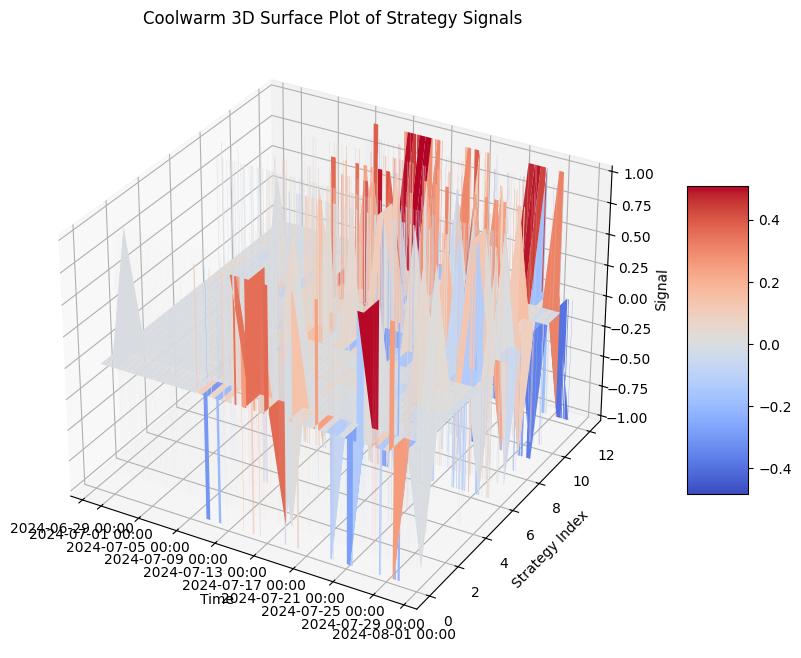

In [88]:
# 将时间转换为 matplotlib 日期格式
X, Y = np.meshgrid(mdates.date2num(df_signals.index), np.arange(df_signals.shape[1]))
Z = df_signals.T.values

# 创建3D表面图
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制3D表面
surf = ax.plot_surface(X, Y, Z, cmap='coolwarm', edgecolor='none')

ax.set_xlabel('Time')
ax.set_ylabel('Strategy Index')
ax.set_zlabel('Signal')
plt.title("Coolwarm 3D Surface Plot of Strategy Signals")

# 添加颜色条
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# 将 X 轴格式化为日期
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

plt.show()

### 均值滤波 (Smoothing via Mean Filtering)

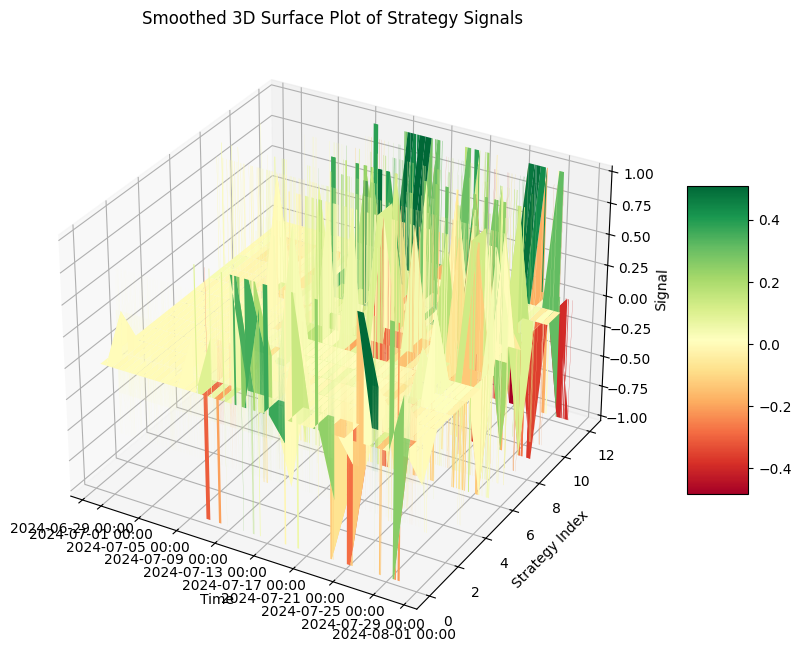

In [72]:
# 应用均值滤波 (窗口大小为3)
df_signals_smoothed = df_signals.rolling(window=3, min_periods=1).mean()

# 将时间转换为 matplotlib 日期格式
X, Y = np.meshgrid(mdates.date2num(df_signals_smoothed.index), np.arange(df_signals_smoothed.shape[1]))
Z = df_signals_smoothed.T.values

# 创建3D表面图
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制3D表面
surf = ax.plot_surface(X, Y, Z, cmap='RdYlGn', edgecolor='none')

ax.set_xlabel('Time')
ax.set_ylabel('Strategy Index')
ax.set_zlabel('Signal')
plt.title("Smoothed 3D Surface Plot of Strategy Signals")

# 添加颜色条
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# 将 X 轴格式化为日期
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

plt.show()

### 双线性插值 (Bilinear Interpolation)

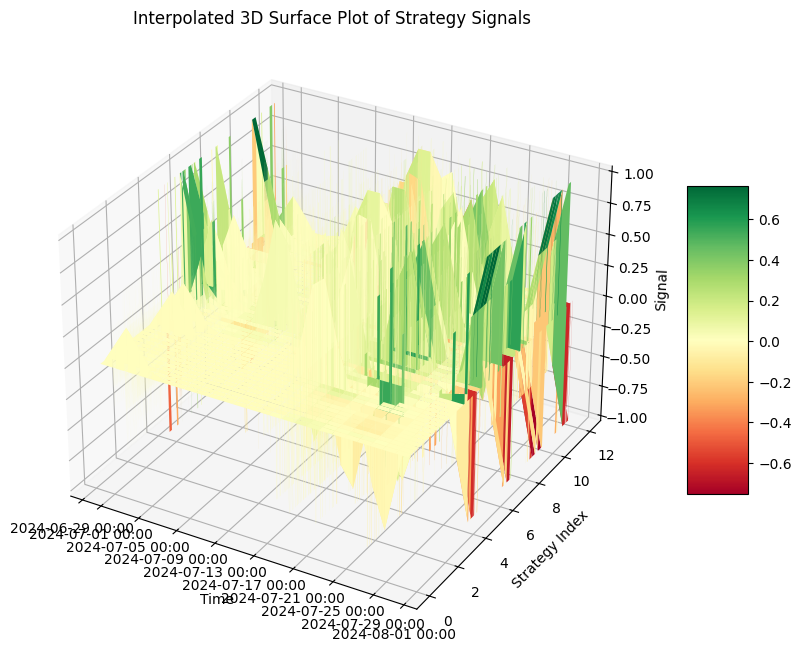

In [74]:
from scipy.ndimage import zoom

# 放大信号矩阵以进行插值
Z_interpolated = zoom(Z, (2, 2), order=1)  # 使用双线性插值

# 创建新的X和Y以匹配插值后的Z
X_interpolated, Y_interpolated = np.meshgrid(
    np.linspace(X.min(), X.max(), Z_interpolated.shape[0]),
    np.linspace(Y.min(), Y.max(), Z_interpolated.shape[1])
)

# 创建3D表面图
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制3D表面
surf = ax.plot_surface(X_interpolated, Y_interpolated, Z_interpolated.T, cmap='RdYlGn', edgecolor='none')

ax.set_xlabel('Time')
ax.set_ylabel('Strategy Index')
ax.set_zlabel('Signal')
plt.title("Interpolated 3D Surface Plot of Strategy Signals")

# 添加颜色条
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# 将 X 轴格式化为日期
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

plt.show()

### Cumulative Signal Plot

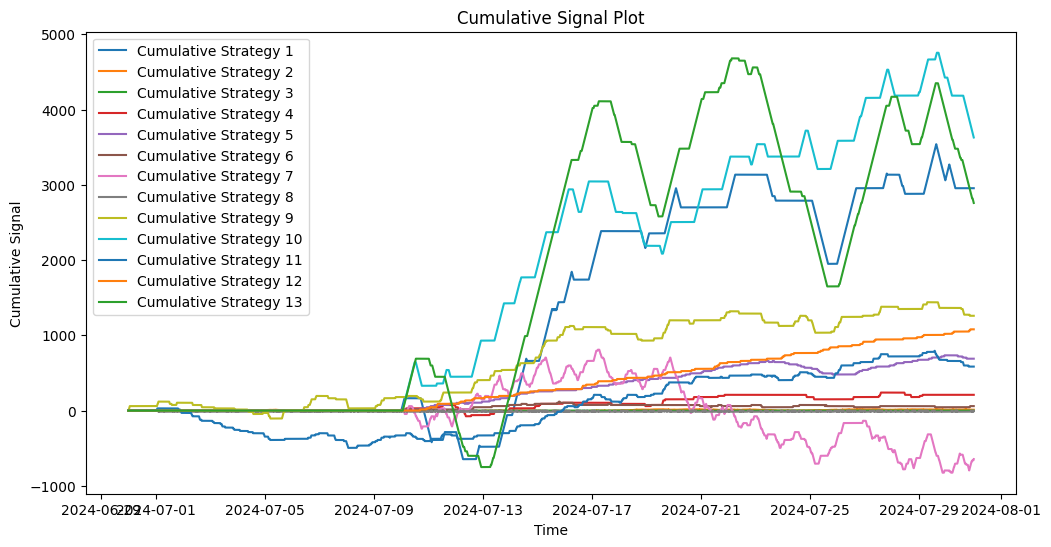

In [89]:
cumulative_signals = df_signals.cumsum()

plt.figure(figsize=(12, 6))

for i in range(cumulative_signals.shape[1]):
    plt.plot(cumulative_signals.index, cumulative_signals.iloc[:, i], label=f"Cumulative Strategy {i+1}")

plt.title("Cumulative Signal Plot")
plt.xlabel("Time")
plt.ylabel("Cumulative Signal")
plt.legend()
plt.show()

### Consensus Plot

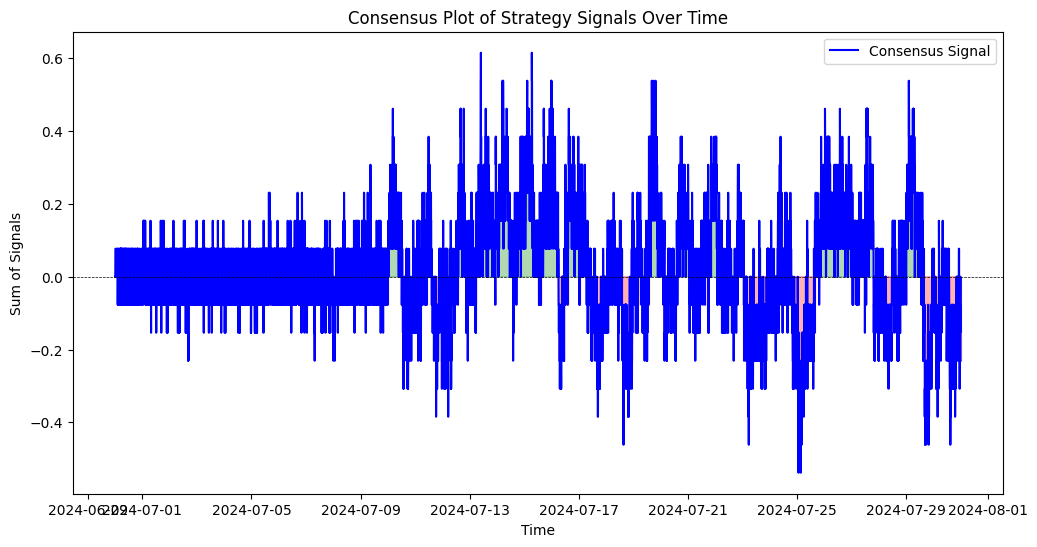

In [76]:
consensus_signal = df_signals.mean(axis=1)

plt.figure(figsize=(12, 6))
plt.plot(df_signals.index, consensus_signal, color='blue', label='Consensus Signal')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.fill_between(df_signals.index, consensus_signal, where=(consensus_signal > 0), color='green', alpha=0.3)
plt.fill_between(df_signals.index, consensus_signal, where=(consensus_signal < 0), color='red', alpha=0.3)
plt.title("Consensus Plot of Strategy Signals Over Time")
plt.xlabel("Time")
plt.ylabel("Sum of Signals")
plt.legend()
plt.show()

### Hourly Resample

In [90]:
consensus_signal_hourly = df_signals.resample("1h").mean().mean(axis=1)

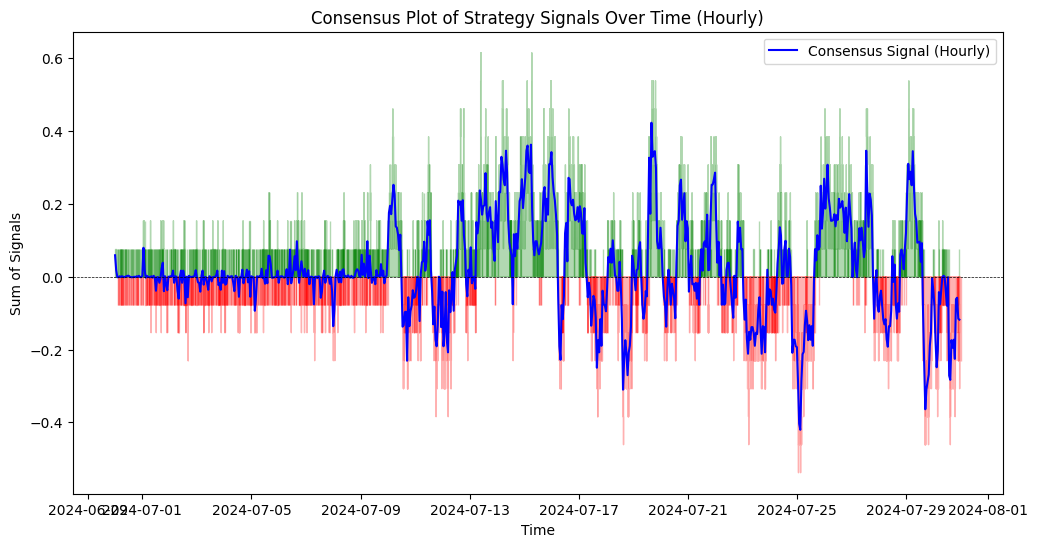

In [95]:
plt.figure(figsize=(12, 6))
plt.plot(df_signals.resample("1h").mean().index, consensus_signal_hourly, color='blue', label='Consensus Signal (Hourly)')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.fill_between(df_signals.index, consensus_signal, where=(consensus_signal > 0), color='green', alpha=0.3)
plt.fill_between(df_signals.index, consensus_signal, where=(consensus_signal < 0), color='red', alpha=0.3)
plt.title("Consensus Plot of Strategy Signals Over Time (Hourly)")
plt.xlabel("Time")
plt.ylabel("Sum of Signals")
plt.legend()
plt.show()